# German Used Cars Dataset -- EDA

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In previous steps, we did a quick inspection of the dataset and fixed some issues related to the data's schema. Now, we will go deeper in our analyses to fully understand the dataset and fix semantic problems with it. Often, several ways of handling these problems will be possible. Depending on the ML model we will use later, they might sometimes even not be problems at all. 

For this reason, the process is not linear and will require going back and forth.

Let's load the clean-ish version of the dataset, assigning data types as we go:

In [ ]:
!head -n 10 data/autos_clean.csv

In [4]:
cars = pd.read_csv(
    "data/autos_clean.csv",
    parse_dates=[0, 12, 14],
    dtype={
        'vehicleType': 'category',
        'monthOfRegistration': 'category',
        'gearbox': 'category',
        'model': 'category',
        'fuelType': 'category',
        'brand': 'category',
        'notRepairedDamage': 'category',
        'postalCode': 'object'
    },
)

# Note: Some older versions of Pandas return an error when specifying dtype "category" 
# for a high-cardinality variable (such as `model`). In that case, comment out the line 
#  with `model` in the command above, and un-comment the command below:
# cars['model'] = cars['model'].astype('category')

cars.head()

dateCrawled    price vehicleType  yearOfRegistration    gearbox  \
0 2016-03-24 11:52:17    480.0         NaN                1993     manual   
1 2016-03-24 10:58:45  18300.0       coupe                2011     manual   
2 2016-03-14 12:52:21   9800.0         SUV                2004  automatic   
3 2016-03-17 16:54:04   1500.0   small car                2001     manual   
4 2016-03-31 17:25:20   3600.0   small car                2008     manual   

   powerPS  model  kilometer monthOfRegistration fuelType       brand  \
0      NaN   golf     150000                 NaN   petrol  volkswagen   
1    190.0    NaN     125000                   5   diesel        audi   
2    163.0  grand     125000                   8   diesel        jeep   
3     75.0   golf     150000                   6   petrol  volkswagen   
4     69.0  fabia      90000                   7   diesel       skoda   

  notRepairedDamage dateCreated postalCode            lastSeen  
0               NaN  2016-03-24      70435 2016-04-07 03:16:57  
1               yes  2016-03-24      66954 2016-04-07 01:46:50  
2               NaN  2016-03-14      90480 2016-04-05 12:47:46  
3                no  2016-03-17      91074 2016-03-17 17:40:17  
4                no  2016-03-31      60437 2016-04-06 10:17:21

In [5]:
cars.dtypes

dateCrawled            datetime64[ns]
price                         float64
vehicleType                  category
yearOfRegistration              int64
gearbox                      category
powerPS                       float64
model                        category
kilometer                       int64
monthOfRegistration          category
fuelType                     category
brand                        category
notRepairedDamage            category
dateCreated            datetime64[ns]
postalCode                     object
lastSeen               datetime64[ns]
dtype: object

## Train / Test Split
Before we start exploring the dataset, we should split it in two parts: the training set, which will be used to train the machine learning model, and the test set, which will be used to evaluate it.
Why? Because by exploring the data, we will learn properties about it that we will use in our modelling. If we kept the dataset as one entity, we might learn things from the test part of the data, which would lead to our model to exploit knowledge that it is not supposed to have access to. In other words, it would be cheating. The risk, then, is that when completely new observations come in, they might not share these learned properties and the model would then perform poorly on them. This phenomenon is known as "data leakage" and can be difficult to detect. We must be very careful in everything we do to ensure it doesn't happen.

Since we have quite a lot of data, let's use 10% of it as the test set.

In [6]:
np.random.seed(0)  # this is key to get the same data every time
train_idx = np.random.choice(cars.index, size=round(len(cars) * 0.9), replace=False)
cars_train = cars.loc[train_idx]
cars_test = cars.loc[cars.index.difference(cars_train.index)]

In [7]:
cars_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334358 entries, 209366 to 286193
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          334358 non-null  datetime64[ns]
 1   price                324667 non-null  float64       
 2   vehicleType          300240 non-null  category      
 3   yearOfRegistration   334358 non-null  int64         
 4   gearbox              316183 non-null  category      
 5   powerPS              297539 non-null  float64       
 6   model                315937 non-null  category      
 7   kilometer            334358 non-null  int64         
 8   monthOfRegistration  300414 non-null  category      
 9   fuelType             304333 non-null  category      
 10  brand                334358 non-null  category      
 11  notRepairedDamage    269483 non-null  category      
 12  dateCreated          334358 non-null  datetime64[ns]
 13  postalCod

## Single Numerical Variables
Let's look at how each numerical variable is distributed in isolation. The `describe()` methods computes some basic statistics for all of them in one go:

In [8]:
cars_train.describe()

price  yearOfRegistration        powerPS      kilometer
count  3.246670e+05       334358.000000  297539.000000  334358.000000
mean   1.812756e+04         2004.644384     129.677652  125601.241783
std    3.826005e+06           94.533512     194.757220   40125.088999
min    1.000000e+00         1000.000000       1.000000    5000.000000
25%    1.250000e+03         1999.000000      80.000000  125000.000000
50%    3.000000e+03         2003.000000     116.000000  150000.000000
75%    7.498000e+03         2008.000000     150.000000  150000.000000
max    2.147484e+09         9999.000000   20000.000000  150000.000000

We notice that the mean and median prices are very different from one another, which typically indicates a skewed distribution. 

In [9]:
num_vars = cars_train.select_dtypes(['int64', 'float64'])

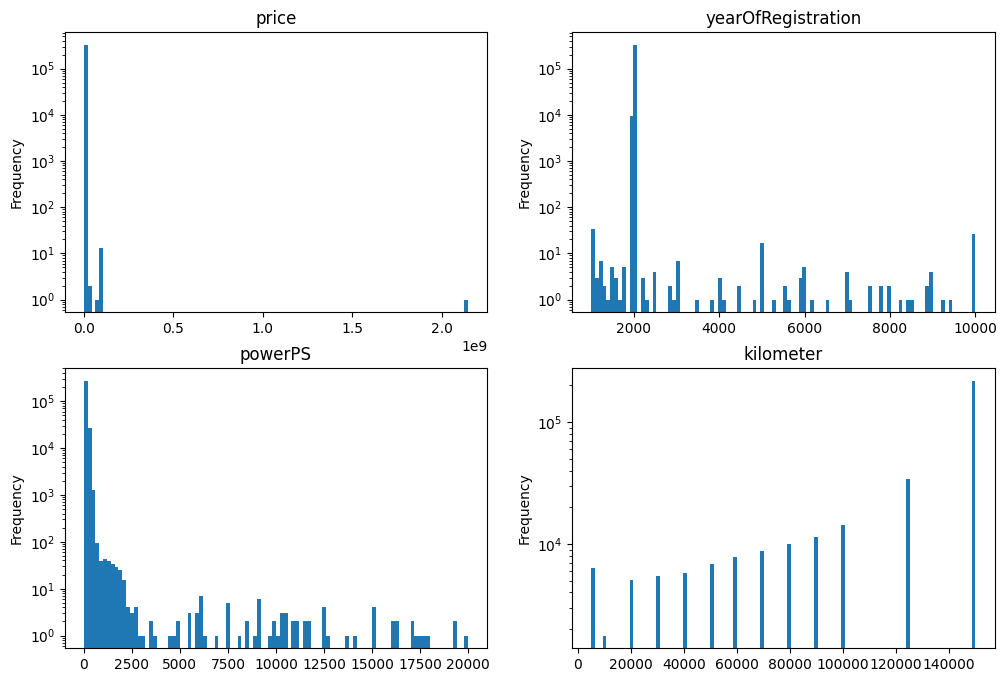

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, c in enumerate(num_vars.columns):
    ax = axs[i//2, i%2]
    cars_train[c].plot(kind='hist', logy=True, ax=ax, bins=100)
    ax.set_title(c)

Note that we had to use a logarithmic y-scale to be able to see some of the outlier bars. As in the data inspection phase, we see that `price`, `yearOfRegistration` and `powerPS` have most of their values concentrated in a fairly narrow band of values, but outliers stretch out very far to the right (and in `yearOfRegistration`'s case, to the left). We will need to decide what to do with these. 

For feature variables (`yearOfRegistration`, `powerPS`), the options are:
- __Drop the corresponding rows__ 
    - Pros: Fairly easy to do once we figure out where to set the threshold; does not force us to "invent" values
    - Cons: Reduces the amount of data available; might make us remove some legitimate and useful observations; how do we handle test set observations that have outlier values? Do we ignore them (e.g. return an error message for these)? Clip them? Let the model use the values (different models have different responses to features whose values are outside the range seen during training)?
- __Clip the variables to some min and max values, or a min and max distance to the mean__
    - Pros: Simple heuristic; lets us keep all observations; at evaluation time, we can apply the same clipping strategy.
    - Cons: Might skew the distribution unrealistically; not obvious how to set the limits.
- __Use some other heuristic to replace outliers, using domain knowledge.__ For instance, we could decide to drop all observations with power over 300bhp, unless they are from a "premium" brand (which have more powerful vehicles).
    - Pros: Could potentially give a more realistic dataset; injects some domain knowledge into the model.
    - Cons: Requires more work and expertise; if done wrong, can negatively impact data quality and create biases; the same heuristic needs to be implemented for test observations.
    
Ideally, we would try each of these approaches, with different configurations for each, and retain the one that works best with each model. However, assuming with try each approach with two different configurations each, we multiply the number of data configurations to test by 6. This is illustrates one of the difficulties of Data Science: The number of experiments increases exponentially with the number of choices we allow ourselves to make. Although some tools such as AutoML can explore this space more efficiently than humans, there is a limit to how many different configurations we can try. This means that we will usually have to make some hard choices, based on our knowledge, experience, and intuition. We will see below the strategies that we decided to follow for each variable.

As for `price`, this is our target variable, so we need to be extra careful. If we feed our model with data that has unrealistic labels, it will learn unrealistic things. So unless we know exactly how to fix these unrealistic values (which is unlikely, otherwise we probably would not need a predictive model), our best course of action is probably to remove these rows entirely.  So let's look at `price` first:


### Price
We saw that `price` is severely skewed with a long right-hand tail. A common technique to make skewed variables look more like a normal distribution is to apply a logarithmic function. This achieves two things:
- The data is easier to visualise (although it is harder to interpret, because the x-scale now gives us the log value rather than the variable's direct value),
- In the modelling phase, this helps some model classes achieve better accuracy.

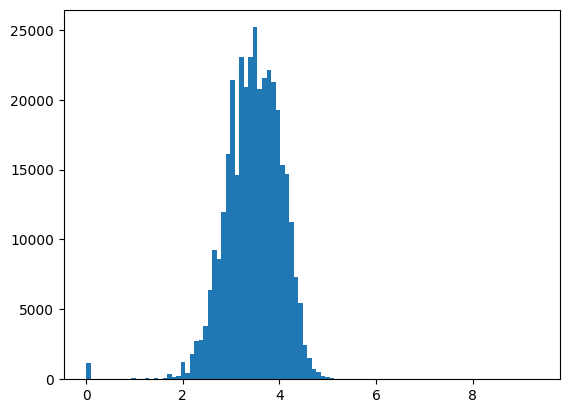

In [11]:
his = plt.hist(np.log10(cars.price), bins=100) # base-10 log is easier to interpret than log of other bases

This works very well here: The variable look normally distributed after log transformation. Since we already removed the observations where `price==0` (we decided they were NaNs), we don't have to worry about instances of log(0), which is undefined. Otherwise, we could have used log(x + 1) for instance instead of log(x).


`plt.hist()` returns a tuple of arrays, the first array containing the frequencies of each bin, and the second array the starting point of each bin, plus the end point of the last bin (therefore it contains one more value than the frequencies array). Let's examine these bins:

In [12]:
price_hist = pd.DataFrame({'counts': his[0], 'bin_start': his[1][:-1]})
price_hist.head(30)

counts  bin_start
0   1189.0   0.000000
1      0.0   0.093319
2      0.0   0.186639
3     12.0   0.279958
4      0.0   0.373277
5      8.0   0.466596
6      1.0   0.559916
7     26.0   0.653235
8      0.0   0.746554
9     12.0   0.839874
10    92.0   0.933193
11    20.0   1.026512
12    34.0   1.119832
13    62.0   1.213151
14    35.0   1.306470
15    59.0   1.399789
16    21.0   1.493109
17    68.0   1.586428
18   366.0   1.679747
19   151.0   1.773067
20   262.0   1.866386
21  1215.0   1.959705
22   478.0   2.053025
23  1837.0   2.146344
24  2765.0   2.239663
25  2781.0   2.332982
26  3842.0   2.426302
27  6361.0   2.519621
28  9261.0   2.612940
29  8578.0   2.706260

In [13]:
price_hist.tail(50)

counts  bin_start
50   722.0   4.665965
51   492.0   4.759284
52   223.0   4.852604
53   142.0   4.945923
54   107.0   5.039242
55    47.0   5.132561
56    47.0   5.225881
57    29.0   5.319200
58    16.0   5.412519
59    12.0   5.505839
60     8.0   5.599158
61     8.0   5.692477
62     6.0   5.785797
63     4.0   5.879116
64    22.0   5.972435
65     4.0   6.065754
66     2.0   6.159074
67     0.0   6.252393
68     0.0   6.345712
69     2.0   6.439032
70     2.0   6.532351
71     0.0   6.625670
72     0.0   6.718990
73     0.0   6.812309
74     0.0   6.905628
75    31.0   6.998947
76     1.0   7.092267
77     0.0   7.185586
78     0.0   7.278905
79     1.0   7.372225
80     1.0   7.465544
81     0.0   7.558863
82     0.0   7.652182
83     0.0   7.745502
84     1.0   7.838821
85    16.0   7.932140
86     0.0   8.025460
87     0.0   8.118779
88     0.0   8.212098
89     0.0   8.305418
90     0.0   8.398737
91     0.0   8.492056
92     0.0   8.585375
93     0.0   8.678695
94     0.0   8.772014
95     0.0   8.865333
96     0.0   8.958653
97     0.0   9.051972
98     0.0   9.145291
99     1.0   9.238611

From this, it looks like we can consider as outliers any observations with a `log(price)` value below 2 and over 5, i.e. prices below €100 and above €100,000. Let's remove these from the data for the rest of our EDA:

In [14]:
print(f"Number of training observations before: {len(cars_train)}")
cars_train = cars_train.query('(price >= 100) & (price <= 100000)')
print(f"Number of training observations after: {len(cars_train)}")

Number of training observations before: 334358
Number of training observations after: 322044


We removed roughtly 3.6% of the data, but we have enough to go on. Let's do the same with the test data:

In [15]:
print(f"Number of test observations before: {len(cars_test)}")
cars_test = cars_test.query('(price >= 100) & (price <= 100000)')
print(f"Number of test observations after: {len(cars_test)}")

Number of test observations before: 37151
Number of test observations after: 35748


Again, the dataset was reduced by about 3.6%. Note again that by choosing to drop these examples, we deliberately make our model less able to accurately predict prices outside the €100-100,000 range. We just assume that these cases are very rare in real-life deployment. This implies that the actual application will need to have some mechanism to detect such cases and warn the user that the prediction will be off.

Let's check the statistics again (train set only!):

In [16]:
cars_train['price'].describe()

count    322044.000000
mean       5815.253468
std        7559.512303
min         100.000000
25%        1290.000000
50%        3100.000000
75%        7499.000000
max      100000.000000
Name: price, dtype: float64

The mean and median price are now much closer.

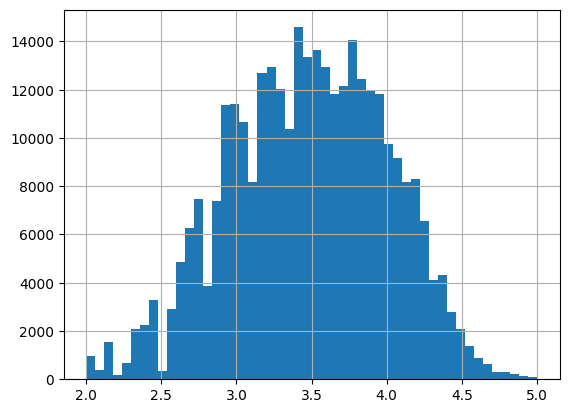

In [17]:
np.log10(cars_train.price).hist(bins=50);

The histogram of `log(price)` exhibits a nice normal-looking distribution.

## powerPS

As we saw during the inspection phase, `powerPS` has outliers stretching out to 20,000. A closer inspection shows that some of these values seem to come from a confusion with engine capacity (cc).

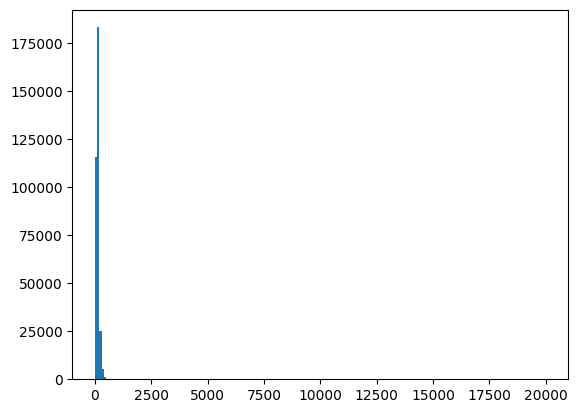

In [18]:
his = plt.hist(cars['powerPS'], bins=200)

In [19]:
power_hist = pd.DataFrame({'counts': his[0], 'bin_start': his[1][:-1]})
power_hist.head(30)

counts  bin_start
0   115778.0      1.000
1   183031.0    100.995
2    24908.0    200.990
3     5100.0    300.985
4     1046.0    400.980
5      379.0    500.975
6       81.0    600.970
7       28.0    700.965
8       13.0    800.960
9       28.0    900.955
10      30.0   1000.950
11      16.0   1100.945
12      17.0   1200.940
13      23.0   1300.935
14      13.0   1400.930
15      24.0   1500.925
16       8.0   1600.920
17      25.0   1700.915
18       6.0   1800.910
19      20.0   1900.905
20      13.0   2000.900
21       2.0   2100.895
22       1.0   2200.890
23       3.0   2300.885
24       2.0   2400.880
25       1.0   2500.875
26       0.0   2600.870
27       4.0   2700.865
28       0.0   2800.860
29       1.0   2900.855

600 or 700PS seems to be a threshold in the data frequency. Let's look at the brands represented around this interval in more detail:

In [20]:
cars_train.query('650 > powerPS > 500').brand.value_counts()

mercedes_benz    121
bmw               60
audi              44
other             24
porsche           21
jaguar            12
volkswagen        10
chevrolet          7
nissan             4
ford               4
renault            3
opel               3
smart              1
lancia             1
land_rover         1
suzuki             1
toyota             1
mitsubishi         1
seat               1
skoda              0
saab               0
rover              0
subaru             0
peugeot            0
trabant            0
alfa_romeo         0
mini               0
mazda              0
lada               0
kia                0
jeep               0
hyundai            0
honda              0
fiat               0
daihatsu           0
daewoo             0
dacia              0
citroen            0
chrysler           0
volvo              0
Name: brand, dtype: int64

Most of these brands are high-end with powerfull models. There are definitely a few errors there (Renaults and Opels above 500PS??) but the data looks mostly sensible.

In [21]:
cars_train.query('powerPS > 650').brand.value_counts()

volkswagen       62
opel             45
audi             30
bmw              26
ford             25
mercedes_benz    24
renault          16
citroen          12
fiat             10
peugeot           7
mitsubishi        6
seat              5
other             5
nissan            5
smart             4
toyota            4
skoda             3
mini              3
volvo             3
honda             3
alfa_romeo        2
lancia            2
chevrolet         2
kia               2
chrysler          1
suzuki            1
dacia             1
daewoo            1
mazda             1
porsche           1
hyundai           1
land_rover        0
saab              0
daihatsu          0
subaru            0
jaguar            0
jeep              0
trabant           0
lada              0
rover             0
Name: brand, dtype: int64

In contrast, looking at brands with observations above 650PS gives us a list of pretty much all brands on the markets, with frequencies that look relatively consistent with the market distribution. This would indicate that these values are mostly input errors. So let's set everything above 650PS as NaNs.

In [22]:
print(f"Number of NaNs in powerPS before: {cars_train.powerPS.isnull().sum()}")
cars_train.loc[cars_train.powerPS > 650, 'powerPS'] = np.nan
print(f"Number of NaNs in powerPS after: {cars_train.powerPS.isnull().sum()}")

Number of NaNs in powerPS before: 32125
Number of NaNs in powerPS after: 32438


We only added about 300 NaNs. Of course, we need to do the same to the test set:

In [23]:
print(f"Number of NaNs in powerPS before: {cars_test.powerPS.isnull().sum()}")
cars_test.loc[cars_test.powerPS > 650, 'powerPS'] = np.nan
print(f"Number of NaNs in powerPS after: {cars_test.powerPS.isnull().sum()}")

Number of NaNs in powerPS before: 3464
Number of NaNs in powerPS after: 3502


A similar analysis shows that 25PS is a sensible lower threshold (the old Trabant outputs only 26PS!).

In [24]:
print(f"Number of NaNs in powerPS before: {cars_train.powerPS.isnull().sum()}")
cars_train.loc[cars_train.powerPS < 25, 'powerPS'] = np.nan
print(f"Number of NaNs in powerPS after: {cars_train.powerPS.isnull().sum()}")
print(f"Number of NaNs in powerPS before: {cars_test.powerPS.isnull().sum()}")
cars_test.loc[cars_test.powerPS < 25, 'powerPS'] = np.nan
print(f"Number of NaNs in powerPS after: {cars_test.powerPS.isnull().sum()}")

Number of NaNs in powerPS before: 32438
Number of NaNs in powerPS after: 32892
Number of NaNs in powerPS before: 3502
Number of NaNs in powerPS after: 3552


Let's plot `powerPS` again:

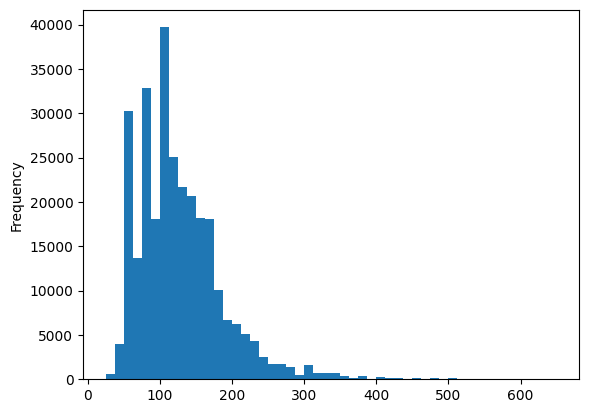

In [25]:
cars_train.powerPS.plot(kind='hist', bins=50);

The distribution is still quite skewed, let's try log transformation:

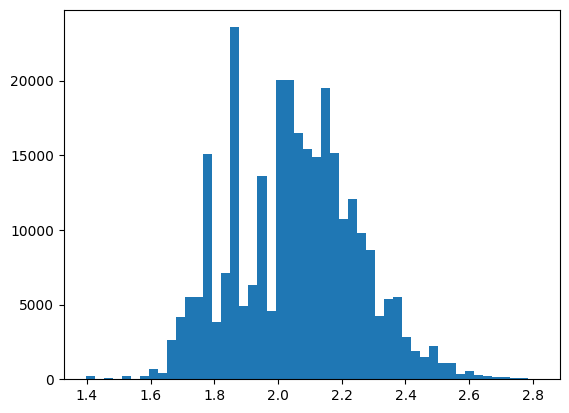

In [26]:
plt.hist(np.log10(cars_train.powerPS), bins=50);

This is looking roughly normal (with some peaks); we will neeed keep this in mind when trying some model classes.

### yearOfRegistration
We saw earlier that some cars were supposedly registered in 1000, and others in 9,999. Both cases are ridiculous. At least, we have an upper bound on the registration date: It cannot be after the year when 
this data was crawled. Let's zoom in on the period 1900-2016:

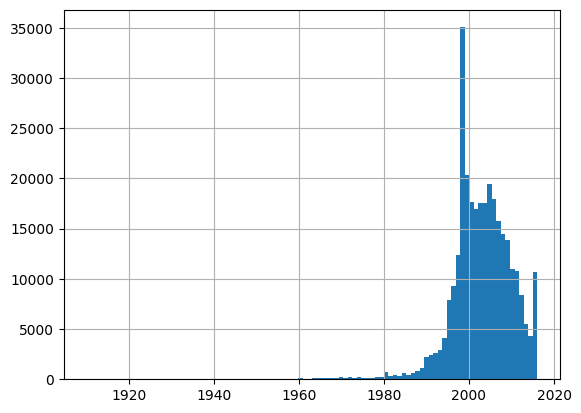

In [27]:
cars_train.query('1900 <= yearOfRegistration <= 2016')['yearOfRegistration'].hist(bins=100);

So it looks like 1960 would be a good lower bound.

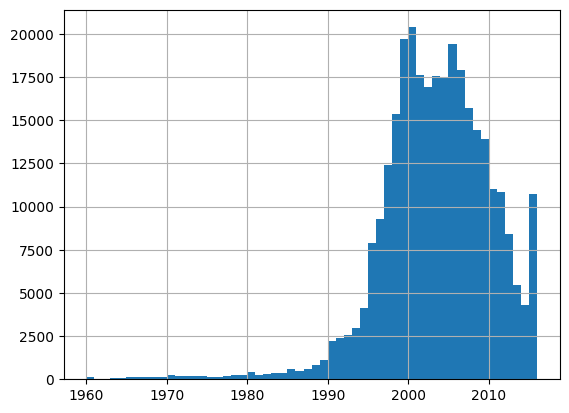

In [28]:
cars_train.query('1960 <= yearOfRegistration <= 2016')['yearOfRegistration'].hist(bins=56);
# number of bins chosen to give us one bar per year

The peak in 2016 is surprising, because the data was collected in April 2016 so there shouldn't be that many cars from that same year. There is a strong suspicion than the current year is actually the default value in the input field. In this case, we could assume that most 2016 observations are actually NaNs. However, some would be genuine current year registrations. This is where a heuristic could be useful, for instance keep 2016 as the registration year for cars with less than 10,000km, and set the others to NaN. Let's see what this would give us:

In [29]:
# Set obvious errors to NaN
cars_train.loc[
    (cars_train['yearOfRegistration'] > 2016) |
    (cars_train['yearOfRegistration'] < 1960),
    'yearOfRegistration'
] = np.nan
cars_test.loc[
    (cars_test['yearOfRegistration'] > 2016) |
    (cars_test['yearOfRegistration'] < 1960),
    'yearOfRegistration'
] = np.nan

# Set NaNs following our rule
cars_train.loc[
    (cars_train['yearOfRegistration'] == 2016) &
    (cars_train['kilometer'] > 10000),
    'yearOfRegistration'
] = np.nan
cars_test.loc[
    (cars_test['yearOfRegistration'] == 2016) &
    (cars_test['kilometer'] > 10000),
    'yearOfRegistration'
] = np.nan


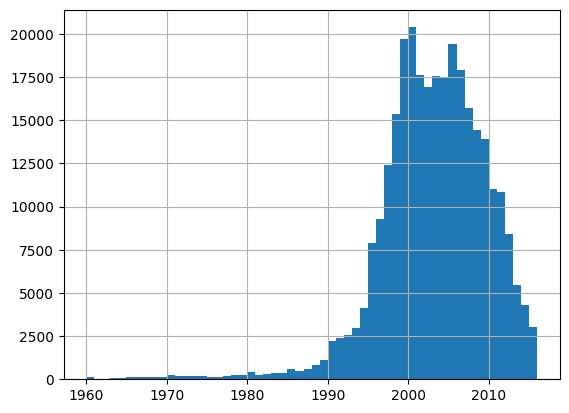

In [30]:
cars_train.yearOfRegistration.hist(bins=56);

This looks much more sensible.

### Kilometer

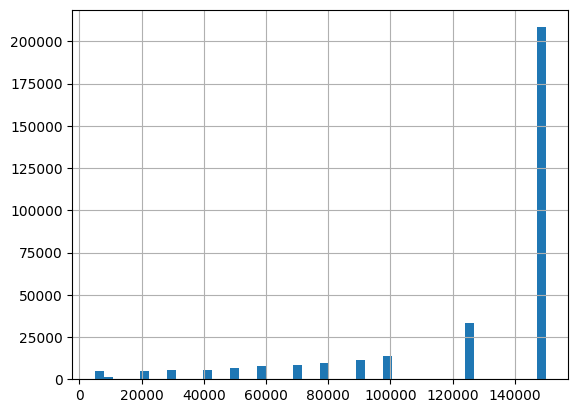

In [31]:
cars_train.kilometer.hist(bins=50);

The histogram reveals that `kilometer` is actually not a continuous variable! Users probably choose a value range from a drop-down box. 

In [32]:
np.sort(cars_train.kilometer.unique())

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

So we have two options: Treat it as a discrete ordinal variable, or treat it as a continuous variable. One problem with the former is that it ignores the size of the gaps between the possible values. Going from 5,000 to 10,000 might not have the same impact on price as going from 125,000 to 150,000. But then again, maybe it does according to an expert at eBay who designed this menu? On the other hand, 150,000km here actually means ">=150,000" and might actually include vehicles with much higher mileage, which would also cause issues to a linear regression model, for instance.

The other thing to note is that the distribution is left-skewed this time. Let's see if we can redress it. In the case of a left skew, it is common to take the logarithm of the reflected data:

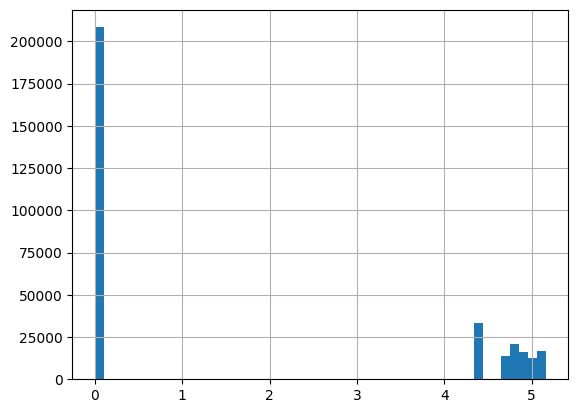

In [33]:
reflected = cars_train.kilometer.max() - cars_train.kilometer
np.log10(reflected + 1).hist(bins=50);  # +1 avoids undefined log(0)

Unfortunately in this case, this strategy fails due to the discrete nature of the variable. The log function tends to spread out lower values and bunch up the higher ones, thus increasing the count in the higher-end bins. But in this case, the density of the data is just not enough for this to correct the skew. We can try more sophisticated methods:

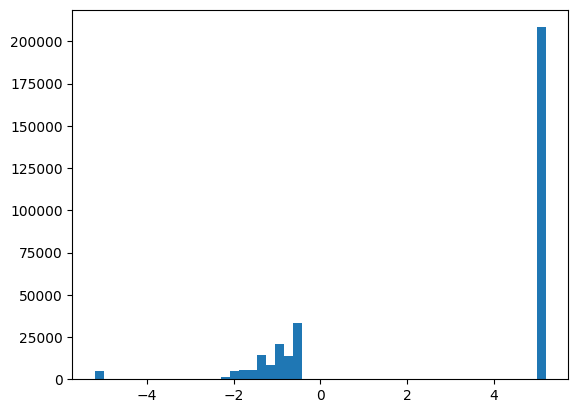

In [36]:
from sklearn.preprocessing import quantile_transform

km_no_na = cars_train.kilometer.fillna(value=cars_train.kilometer.median())
plt.hist(
    quantile_transform(
        km_no_na.values.reshape(-1, 1), 
        output_distribution='normal'
    ), bins=50
);

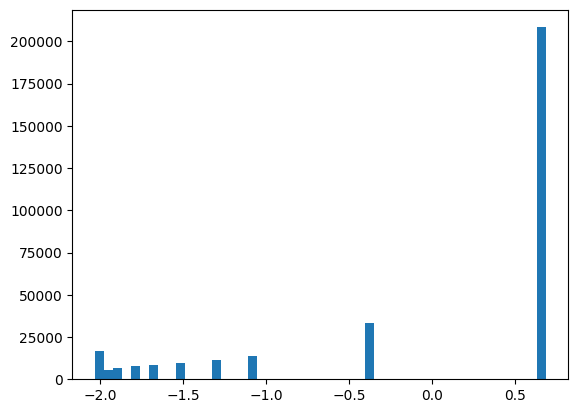

In [37]:
from sklearn.preprocessing import power_transform

km_no_na = cars_train.kilometer.fillna(value=cars_train.kilometer.median())
plt.hist(
    power_transform(
        km_no_na.values.reshape(-1, 1),
        method='box-cox'
    ), bins=50
);

None of these methods give satisfactory results. We will need to watch for this variable when modelling. Linear regression, for instance, assumes that for each X, the y values are normally distributed, which won't be the case here. A categorical encoding might be better in that case...

### Date variables
Date variables are numerical in a sense, but require specific interpretation.

In [38]:
date_vars = cars_train.select_dtypes(['datetime64[ns]'])
date_vars

dateCrawled dateCreated            lastSeen
209366 2016-04-03 21:44:01  2016-04-03 2016-04-05 22:18:48
103595 2016-03-16 21:53:06  2016-03-16 2016-03-27 14:16:01
155641 2016-03-30 16:54:13  2016-03-30 2016-04-07 08:16:44
45142  2016-03-12 18:56:43  2016-03-12 2016-03-29 04:45:49
222364 2016-03-26 12:46:26  2016-03-26 2016-04-06 00:17:07
...                    ...         ...                 ...
260147 2016-03-20 17:53:10  2016-03-20 2016-04-05 19:47:56
248564 2016-03-26 09:56:20  2016-03-26 2016-03-26 09:56:20
222828 2016-03-31 17:47:45  2016-03-31 2016-04-02 13:18:02
106836 2016-03-29 13:49:29  2016-03-29 2016-04-05 23:17:23
286193 2016-04-03 19:18:58  2016-04-02 2016-04-06 12:17:29

[322044 rows x 3 columns]

__Caveat__:
Although the analysis that follows is interesting and is provided for illustration, let's not lose sight of our target: To deploy an online prediction system. Fields such as `dateCrawled`, `dateCreated`, and `lastSeen` do not make sense in this context, so for our particular application, we will need to drop these two columns once we move on to the next phase.

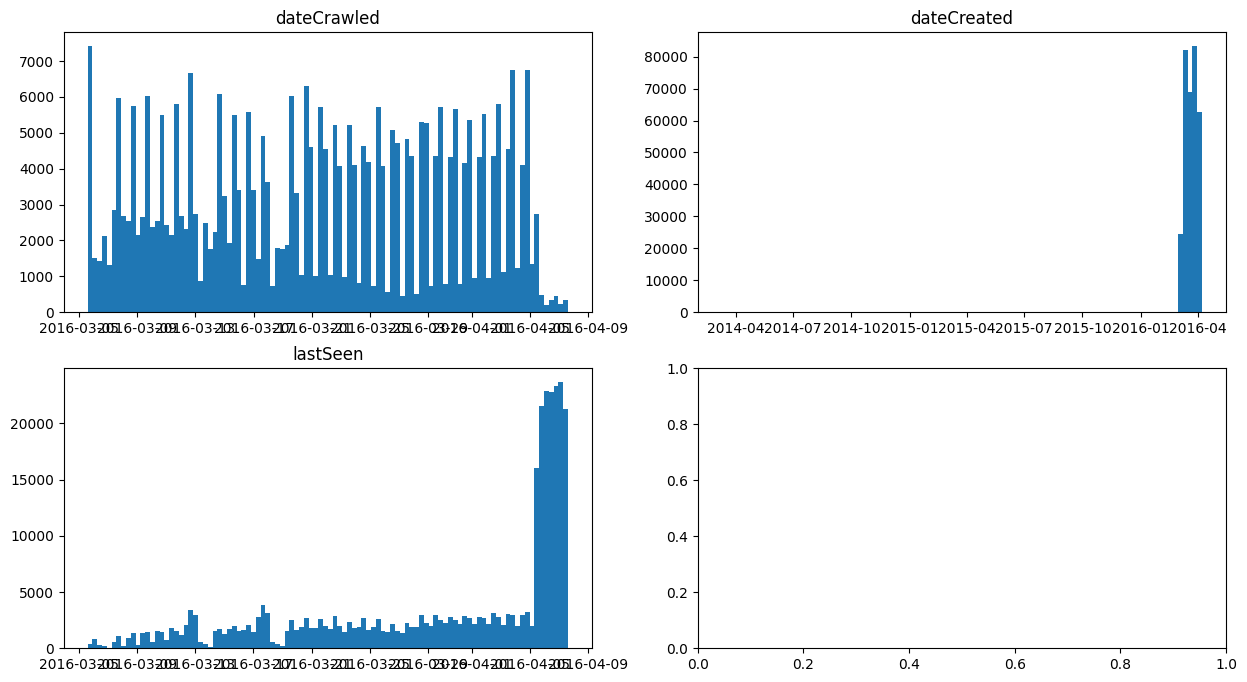

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for i, c in enumerate(date_vars.columns):
    ax = axs[i//2, i%2]
    ax.hist(cars_train[c], bins=100)
    ax.set_title(c)

In [40]:
cars_train.dateCrawled.nunique()

252788

`dateCrawled` is simply the date when each observation was collected. Its distribution is fairly uniform, its range is very limited, and seems to be almost as many different values as there are observations. As a result, it is probably not going to be very informative and we might be better off just dropping it. This simplifies the dataset further.

Remember that although we don't want to learn anything about the data from the test set, we must apply to it any transformations that we apply to the training set, otherwise our models will not be able to make predictions on the test set.

In [41]:
cars_train.drop('dateCrawled', axis=1, inplace=True)
cars_test.drop('dateCrawled', axis=1, inplace=True)

As for the other two datetime variables, let's compare their distributions in closer detail:

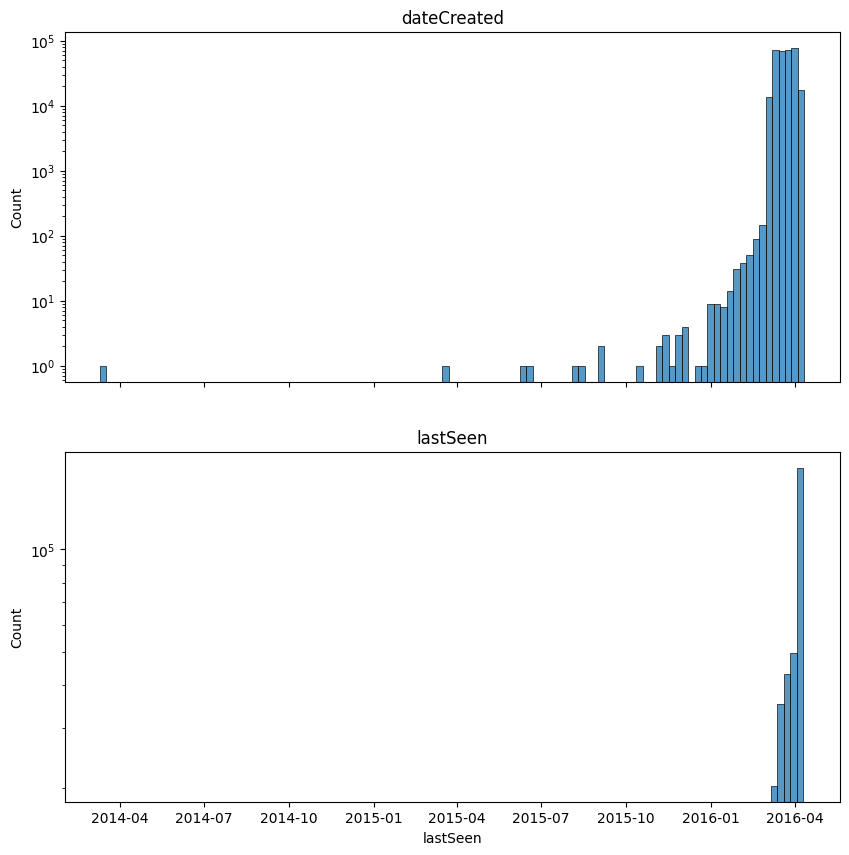

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for i, c in enumerate(['dateCreated', 'lastSeen']):
    ax = axs[i]
    sns.histplot(data=cars_train[c], binwidth=7, ax=ax)  # set bin widths to one week
    ax.set_yscale('log')
    ax.set_title(c)

Several things stand out:
- The vast majority of examples were created within the last 6 months or so
- All examples were last seen over the last 5 or 6 weeks.

How to interpret these observations? It seems that ads don't stay online very long, probably because most cars are sold relatively quickly, and because the owner takes the ads down after that to avoid paying continued fees (assuming the pricing system is subscription-like). Moreover, it would seem that all ads get viewed over a month or so -- this is maybe more surprising, but without knowing more about how eBay operates, it is difficult to know if this interpretation is correct.

Let's look at the few examples that were created before October 2015:

In [48]:
old_ads = cars_train.query("dateCreated < '2015-10-01'")
old_ads.dateCreated.value_counts()

2015-09-04    2
2015-06-11    1
2015-03-20    1
2014-03-10    1
2015-06-18    1
2015-08-10    1
2015-08-07    1
Name: dateCreated, dtype: int64

In [49]:
old_ads

price     vehicleType  yearOfRegistration    gearbox  powerPS  \
5310    47900.0           sedan              2014.0  automatic      NaN   
4192     6000.0  people carrier              1995.0  automatic    200.0   
79263     600.0       small car              2005.0     manual     54.0   
231754    600.0       small car              2005.0     manual     54.0   
64199    8999.0             NaN              2005.0        NaN      NaN   
358873  10400.0  people carrier              1993.0        NaN      NaN   
183648   5200.0     convertible              2006.0     manual    109.0   
90803   14250.0     convertible              2005.0     manual    163.0   

           model  kilometer monthOfRegistration fuelType          brand  \
5310    c_klasse      20000                   2   diesel  mercedes_benz   
4192       other     150000                 NaN   petrol      chevrolet   
79263       polo     150000                   1   petrol     volkswagen   
231754      polo     150000                   1   petrol     volkswagen   
64199        147     125000                 NaN   petrol     alfa_romeo   
358873    ducato      30000                   1   diesel           fiat   
183648   2_reihe      80000                  11   petrol        peugeot   
90803        slk     150000                   6   petrol  mercedes_benz   

       notRepairedDamage dateCreated postalCode            lastSeen  
5310                 NaN  2015-06-11      46145 2016-04-06 09:47:02  
4192                  no  2015-03-20      24558 2016-04-07 03:45:01  
79263                yes  2015-09-04      72669 2016-03-15 14:16:58  
231754               yes  2015-09-04      72669 2016-03-15 15:49:29  
64199                NaN  2014-03-10      79669 2016-04-07 04:46:24  
358873               NaN  2015-06-18      76275 2016-04-05 17:46:09  
183648                no  2015-08-10      26382 2016-04-05 20:46:54  
90803                 no  2015-08-07      76228 2016-04-07 09:15:23

__Note__: Depending on the train/test split you got when running this notebook, some of the following remarks might not apply to you.

Some of these ads have one or more missing values, which might make them less confidence-inspiring. Some others relate to vehicles with very high mileage sold at relatively high prices, which makes them less attractive. In some other cases, it is not immediately obvious why the ad is still online; it might just be that the owner forgot to take it down.


## Single categorical variables

In [50]:
cars_train.head()

price vehicleType  yearOfRegistration gearbox  powerPS     model  \
209366  27500.0         SUV              2015.0  manual    140.0    tiguan   
103595   1300.0   small car              1998.0  manual     90.0  a_klasse   
155641   4500.0         NaN              2006.0     NaN      NaN       NaN   
45142   13000.0         NaN                 NaN     NaN      NaN    tiguan   
222364   3300.0   small car              1998.0  manual    180.0      golf   

        kilometer monthOfRegistration fuelType          brand  \
209366      20000                   3   diesel     volkswagen   
103595     150000                 NaN   petrol  mercedes_benz   
155641     150000                 NaN   diesel     volkswagen   
45142      125000                   3   diesel     volkswagen   
222364     150000                 NaN   petrol     volkswagen   

       notRepairedDamage dateCreated postalCode            lastSeen  
209366                no  2016-04-03      58507 2016-04-05 22:18:48  
103595                no  2016-03-16      47809 2016-03-27 14:16:01  
155641               NaN  2016-03-30      79110 2016-04-07 08:16:44  
45142                NaN  2016-03-12      38272 2016-03-29 04:45:49  
222364                no  2016-03-26      97616 2016-04-06 00:17:07

Before we do anything else, it would be a good idea to order the `monthOfRegistration` column:

In [51]:
cars_train['monthOfRegistration'] = cars_train.monthOfRegistration.cat.reorder_categories(
    [str(s) for s in range(1, 13)],
    ordered=True,
)
cars_train.monthOfRegistration

209366      3
103595    NaN
155641    NaN
45142       3
222364    NaN
         ... 
260147      2
248564      4
222828      6
106836      9
286193      3
Name: monthOfRegistration, Length: 322044, dtype: category
Categories (12, object): ['1' < '2' < '3' < '4' ... '9' < '10' < '11' < '12']

In [52]:
cars_train.head()

price vehicleType  yearOfRegistration gearbox  powerPS     model  \
209366  27500.0         SUV              2015.0  manual    140.0    tiguan   
103595   1300.0   small car              1998.0  manual     90.0  a_klasse   
155641   4500.0         NaN              2006.0     NaN      NaN       NaN   
45142   13000.0         NaN                 NaN     NaN      NaN    tiguan   
222364   3300.0   small car              1998.0  manual    180.0      golf   

        kilometer monthOfRegistration fuelType          brand  \
209366      20000                   3   diesel     volkswagen   
103595     150000                 NaN   petrol  mercedes_benz   
155641     150000                 NaN   diesel     volkswagen   
45142      125000                   3   diesel     volkswagen   
222364     150000                 NaN   petrol     volkswagen   

       notRepairedDamage dateCreated postalCode            lastSeen  
209366                no  2016-04-03      58507 2016-04-05 22:18:48  
103595                no  2016-03-16      47809 2016-03-27 14:16:01  
155641               NaN  2016-03-30      79110 2016-04-07 08:16:44  
45142                NaN  2016-03-12      38272 2016-03-29 04:45:49  
222364                no  2016-03-26      97616 2016-04-06 00:17:07

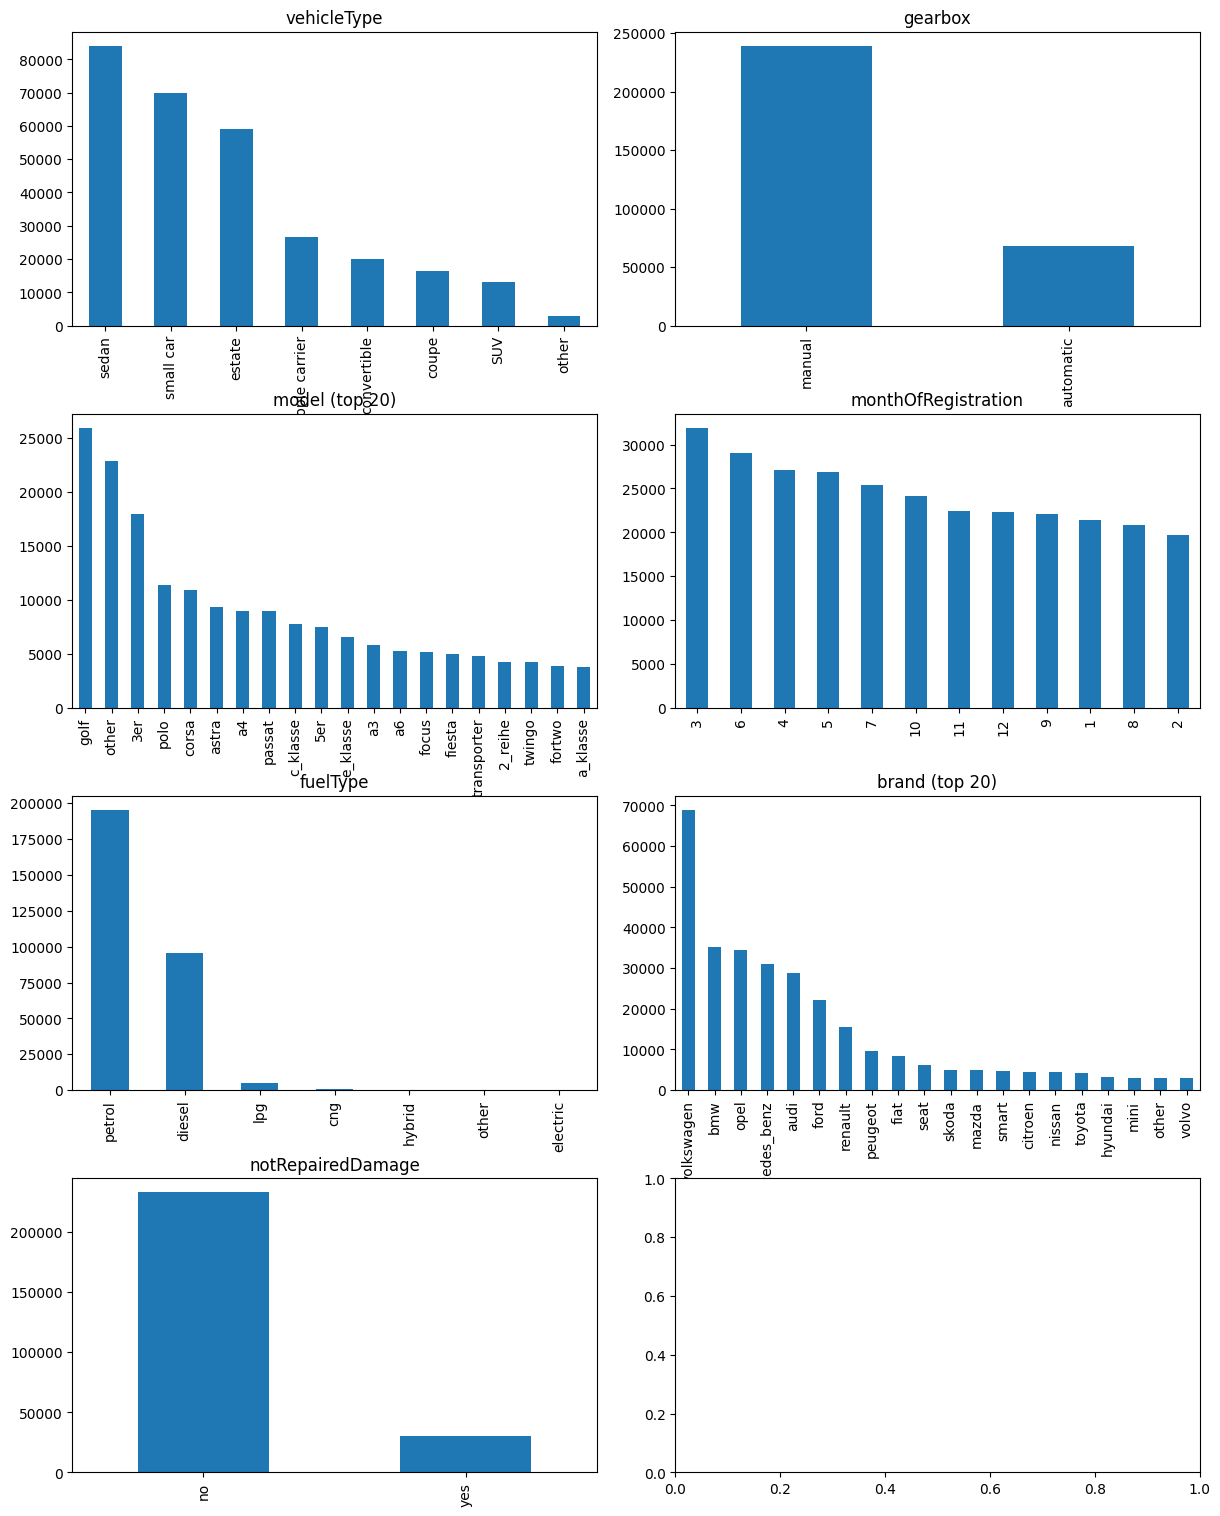

In [53]:
f, axs = plt.subplots(4, 2, figsize=(12,15))
f.tight_layout()
for i, c in enumerate(cars_train.select_dtypes('category')):
    ax = axs[i//2, i%2] 
    cars_train[c].value_counts()[:20].plot(
        kind='bar', 
        ax=ax, 
    )
    if len(cars_train[c].cat.categories) > 20:
        ax.set_title(f'{c} (top 20)')
    else:
        ax.set_title(c)
    plt.subplots_adjust(wspace=0.15, hspace=0.3)

For ease of reading, we are only displaying the top 20 categories when there are more than that. We can see that the different categories have quite different frequencies. A lot of these differences are quite intuitive. For instance:
- Mainstream vehicle types are more common than more exotic ones (e.g. coupes)
- Petrol and Diesel cars are far more common than other forms of energy (especially considering this was back in 2016)
- Some brands and models are much more prominent than others
etc.

Looking at `monthOfRegistration`, we notice that the distribution is not quite uniform. March and June have higher numers. With some research into the German automotive market, we can quickly see that this corresponds to the market's seasonality, with more new vehicles being registered in these two months.

Let's look at the distribution of brands and models more closely:

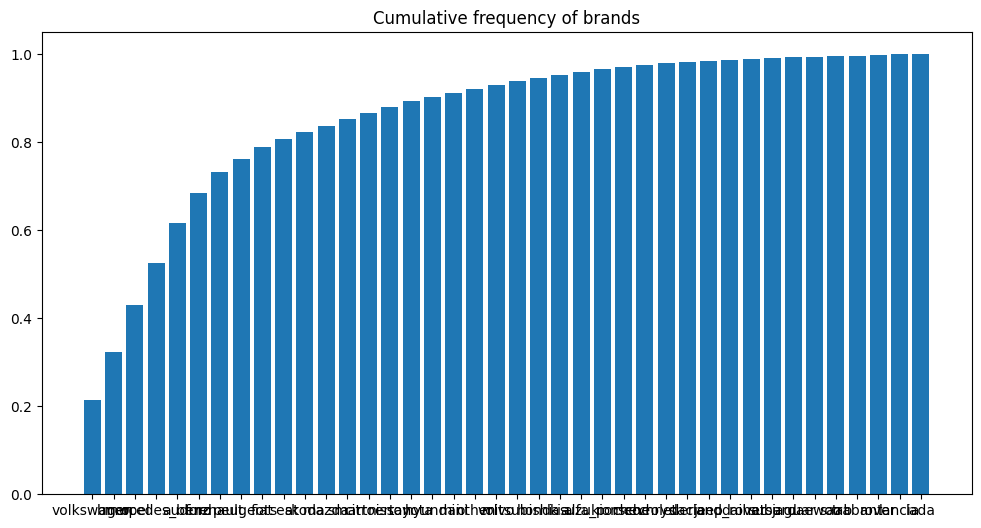

In [54]:
freq_brand = cars_train.brand.value_counts() / len(cars_train)
cum_freq_brand = (cars_train.brand.value_counts().cumsum() / len(cars_train))
_ = plt.figure(figsize=(12, 6))
plt.bar(cum_freq_brand.index, height=cum_freq_brand)
plt.title('Cumulative frequency of brands');

In [55]:
print(f'Total number of brands: {len(freq_brand)}')
threshold = 0.01
print(f'Number of brands under {threshold * 100}%: {len(freq_brand[freq_brand < threshold])}')

Total number of brands: 40
Number of brands under 1.0%: 23


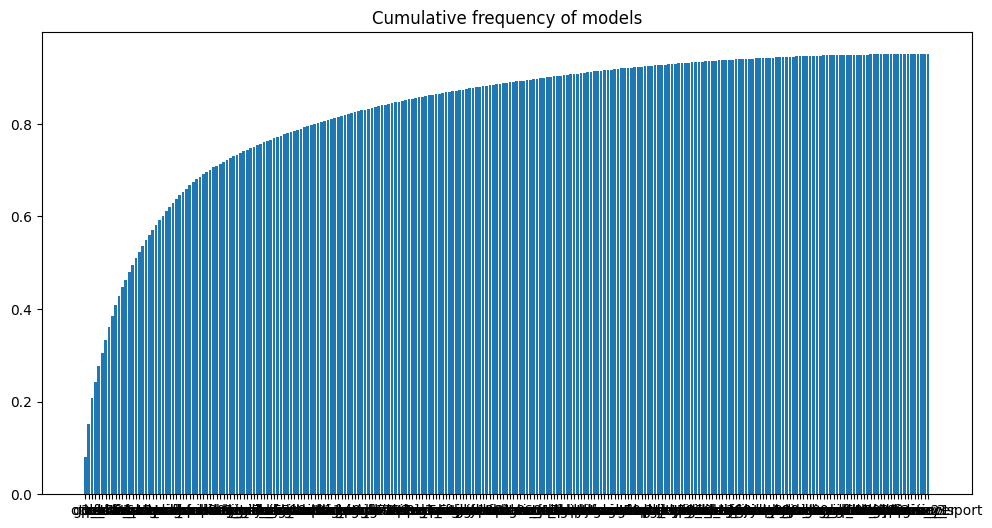

In [56]:
freq_model = cars_train.model.value_counts() / len(cars_train)
cum_freq_model = (cars_train.model.value_counts().cumsum() / len(cars_train))
_ = plt.figure(figsize=(12, 6))
plt.bar(cum_freq_model.index, height=cum_freq_model)
plt.title('Cumulative frequency of models');

In [57]:
print(f'Total number of models: {len(freq_model)}')
threshold = 0.003
print(f'Number of models under {threshold * 100}%: {len(freq_model[freq_model < threshold])}')

Total number of models: 251
Number of models under 0.3%: 197


24 out of 40 brands represent less than 1% of the adverts. It's even worse with models: Most models have low market shares -- 199 out of 251 represent less than 0.3% of the adverts!
This means that the "outliers" are actually the majority in both these variables. We cannot simply remove them or set them to NA. We will have to think of a better strategy.

### Postcode
The last variable left to analyse is `postcode`. We already know that it has thousands of unique value, which makes it impractical to use as a categorical variable. Some research on [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_in_Germany) tells us that like in most countries, post codes have a hierarchical structure: The more digits we go to the right, the smaller the geographical area covered. However, there does not appear to be a consistent structure in how "subcodes" are distributed geographically within the same "supercode". We have two possible approaches:

- Keep postcode as a numerical continuous variable: This maintains the hierarchical nature of postcode (more granularity as we add digits to the right), but linear (and related) models would struggle because there is no obvious semantic relationship between two successive values.
- Encode postcode as a categorical variable, keeping only the first 2 or 3 digits to reduce the number of labels. This is usable by all models, but increases the number of feature variables in the dataset, because each label becomes a variable (assuming we use one-hot encoding, more on this when we study feature engineering).

More complex approachs could include more complex forms of feature encoding (hash, binary, label mean...), or getting access to a database matching postcodes to geographical coordinates and using these (or some derived feature) as inputs. For now, let's stick to the two options above.

Let's see what each of the two approaches above look like and if we can find any structure. First, postcode as numerical. To make the plot half-readable, let's bin values by the thousands:

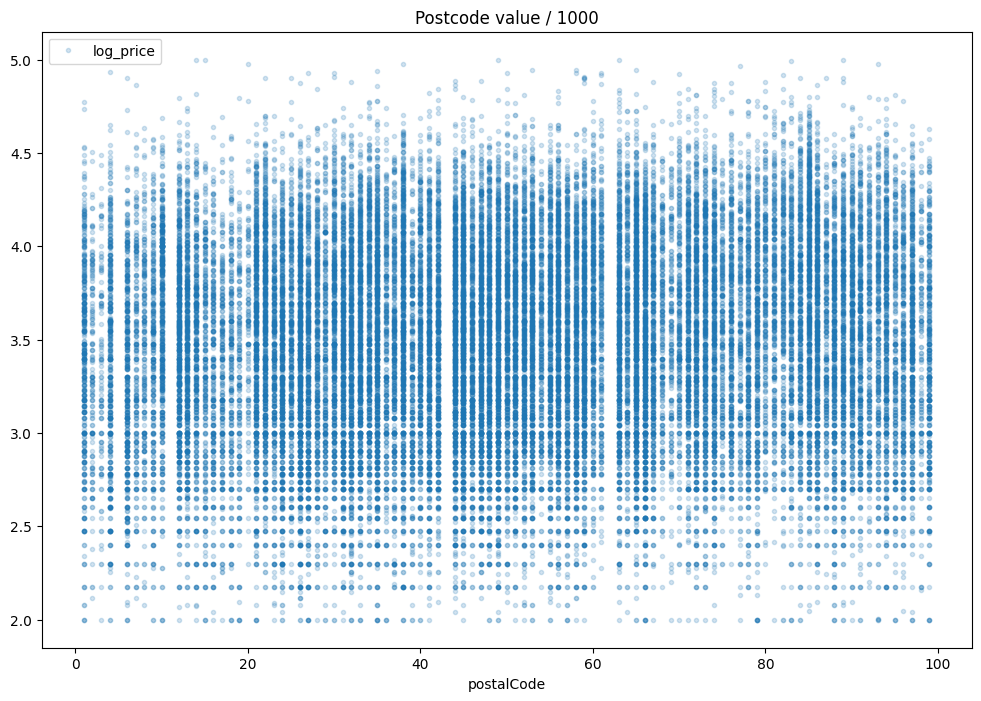

In [58]:
postcode_num = cars_train.loc[
    np.random.choice(cars_train.index, 50000, replace=False),
    ['postalCode', 'price']
].copy().sort_values(by='postalCode')
postcode_num.postalCode = postcode_num.postalCode.astype('float64') // 1000
postcode_num['log_price'] = np.log10(postcode_num.price)
_, ax = plt.subplots(1, 1, figsize=(12,8))
postcode_num.plot(kind='line', x='postalCode', y='log_price', style='.', ax=ax, alpha=0.2)
plt.title("Postcode value / 1000");

Some bands do seem to have higher prices overall, but there isn't really much else we can tell from this. Since we binned postcodes anyway to produce this, we might as well treat them as categorical:

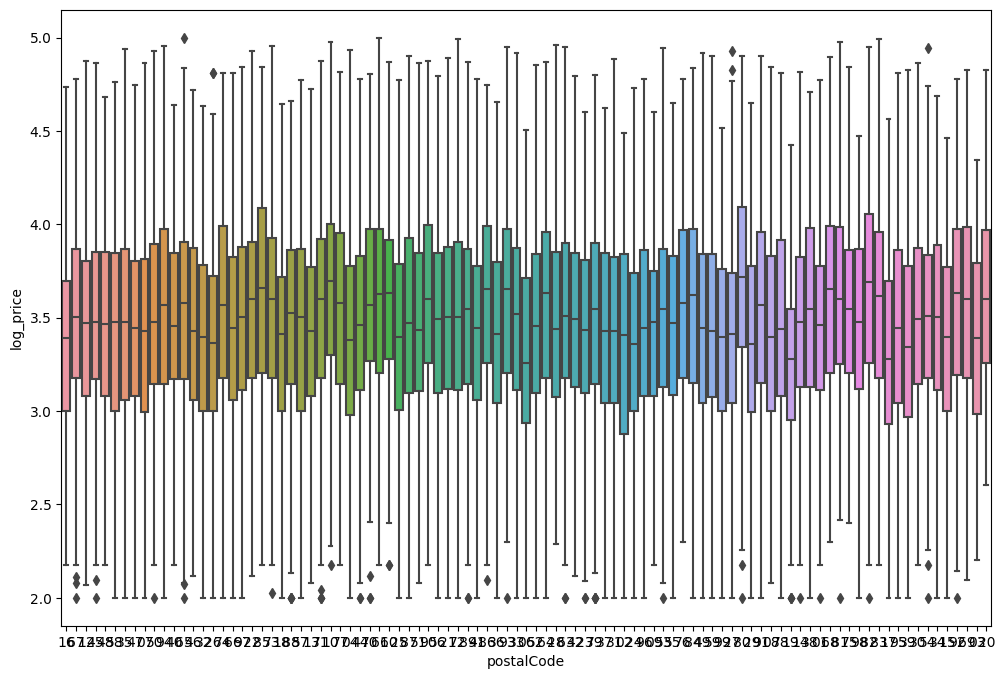

In [59]:
postcode_cat = cars_train.loc[
    np.random.choice(cars_train.index, 50000, replace=False),
    ['postalCode', 'price']].copy()
postcode_cat['log_price'] = np.log10(postcode_cat.price)
postcode_cat.postalCode = postcode_cat.postalCode.str[:2]  # retain only first two digits

_, ax = plt.subplots(1, 1, figsize=(12,8))
sns.boxplot(data=postcode_cat, x='postalCode', y='log_price');

Again, there seems to be fairly sizeable differences between some of the postcode areas, but no ordering or structure along the the postcode values in general. So the categorical representation is probably better. Later, we will see how to make geographical sense of postcodes.

## Pairs of numerical variables 

We now analyse the relationships between pairs of numerical variables, including the target variabel `price`. For this, we can make use of Seaborn's shortcuts. Since this can be a little slow to build, we only use a random subset of the data:

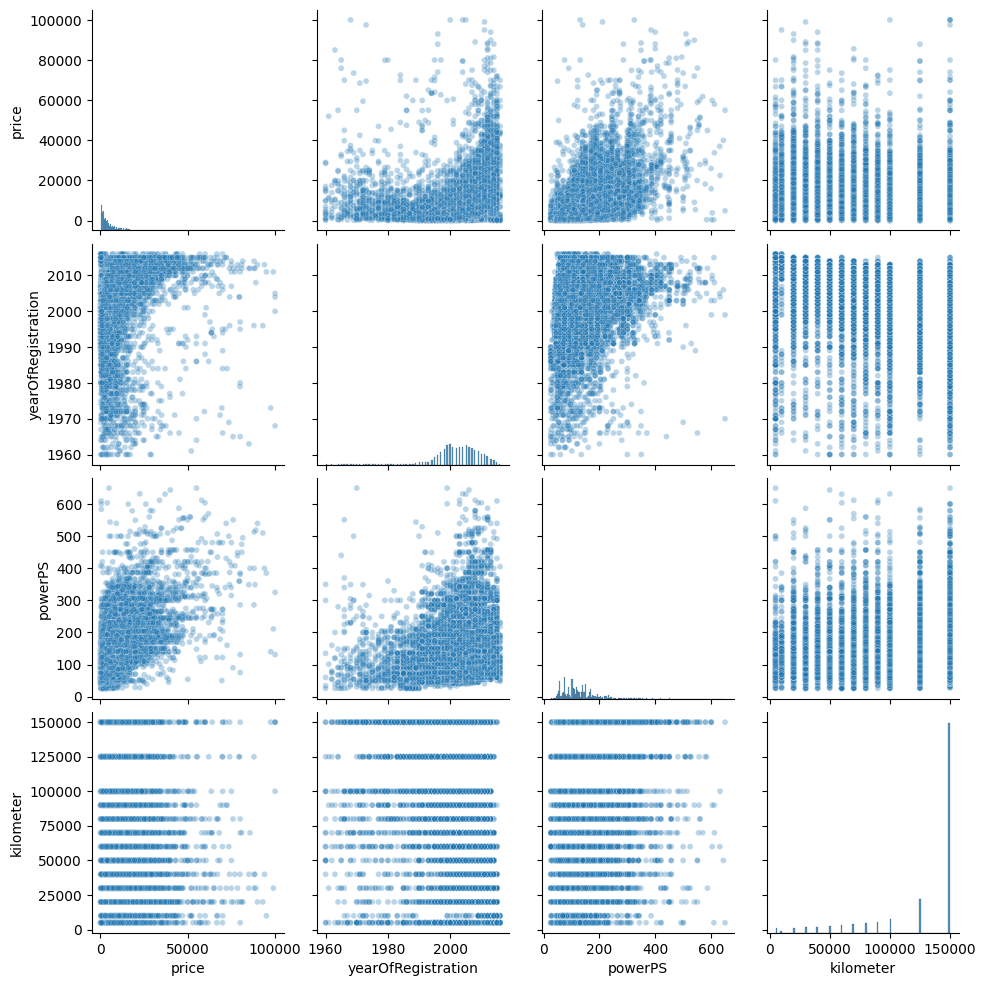

In [60]:
num_vars = cars_train.loc[
    np.random.choice(cars_train.index, 50000, replace=False)
].select_dtypes(['int64', 'float64'])
sns.pairplot(num_vars, kind='scatter', plot_kws={'alpha': 0.3, 'size': 3});

We can immediately see some trends in the data:
- There is some association between `yearOfRegistration` and `powerPS` with `price`. The former does not look like a linear correlation at all and even seem non-monotonous. The latter seems generally positive.
- There is some positive correlation between `powerPS` and `yearOfRegistration`, indicating that cars tends to become more powerfull over the years.
- The relationships involving `kilometer` are harder to read, in part due to the discrete nature of its values.

We should also try to quantify the correlation between numerical variables because highly correlated features can cause stability and accuracy issues.

In [61]:
corr = num_vars.corr()
corr.style.background_gradient(cmap='coolwarm')

Significant linear correlations exist, especially between predictors and `price`. Correlations between predictors (features) are lower. However, this uses Pearson's correlation which assumes normality of the data distribution. Let's try with a rank-correlation metric:

In [62]:
corr = num_vars.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

The correlations are stonger now. None of the correlations between features (`yearOfRegistration`, `powerPS`, and `kilometer`) seem so high as to cause issues with our models, though.

Let's now explore `yearOfRegistration` vs `price` in more detail.

### Year of Registration vs Price


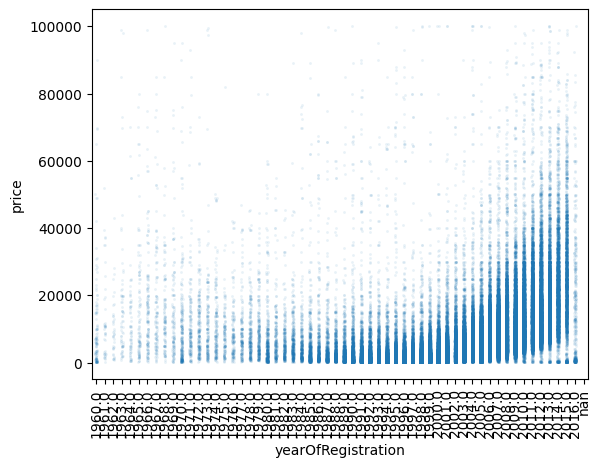

In [63]:
# stripplot is a version of scatterplot that adds jitter to help visualise overlapping dots.
sns.stripplot(
    data=cars_train,
    x='yearOfRegistration',
    y='price',
    alpha=0.1,
    size=2,
    legend=False,
)
plt.xticks(rotation=90);

There is definitely some structure here but is quite difficult to make out the shape of the correlation. But recall that we noted earlier that `log(price)` had a nearly normal distribution. Maybe this could make the plot easier to read.

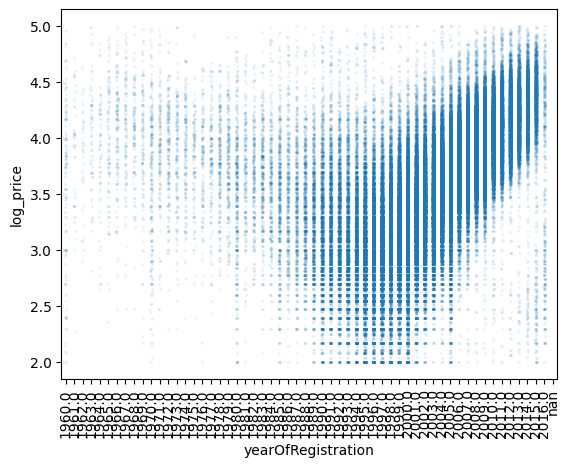

In [64]:
cars_train.loc[:, 'log_price'] = np.log10(cars_train.price)

# do the same to the test set
cars_test.loc[:, 'log_price'] = np.log10(cars_test.price)

sns.stripplot(
    data=cars_train,
    x='yearOfRegistration',
    y='log_price',
    alpha=0.1,
    size=2,
    legend=False,
)
plt.xticks(rotation=90);

Despite the fix, we still have a cluster of recently registered cars with strangely low prices. However, using the logarithmic transformation makes a V-shaped structure appear, with the tip of the V around 1995 or so. This pattern was invisible before applying the log-transform.

How do we interpret this? This is where domain knowledge is required again. One explanation could be that after a certain number of years (which seems to be around 20), vehicles become collection objects and their value starts increasing again. 

This means that if we tried to fit a linear regression against this variable, we would need to distinguish between the case when vehicles are considered as vintage collection items, and the "normal" case. Let's keep this in mind for later!

### powerPS vs Price
Should we be looking at `powerPS` against `price`, or against `log_price`? Let's plot both and let Seaborn fit a regression model on `powerPS`:

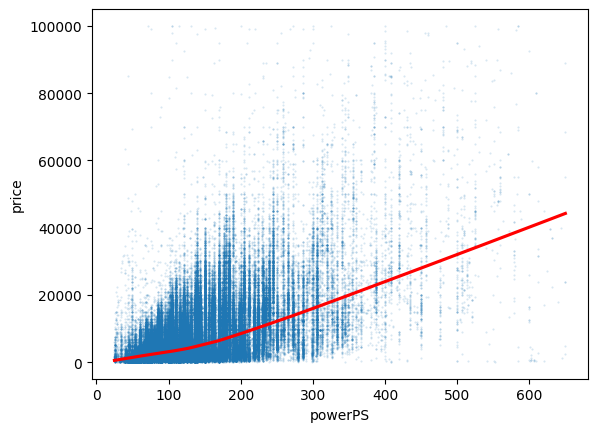

In [65]:
sns.regplot(
    data=cars_train,
    x='powerPS', 
    y='price',
    lowess=True,
    scatter_kws={'alpha': 0.2, 's': 0.2},
    line_kws={'color':'red'},
    );

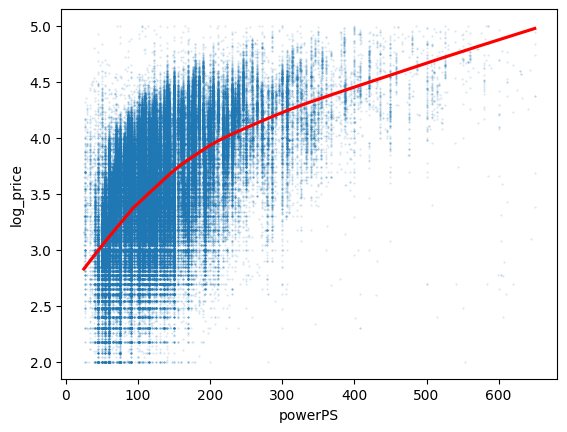

In [66]:
sns.regplot(
    data=cars_train,
    x='powerPS', 
    y='log_price',
    lowess=True,
    scatter_kws={'alpha': 0.2, 's': 0.2},
    line_kws={'color':'red'},
    );

Neither scatter plot seems like a very good fit to the linear regression. Note that the prices are capped at 100,000 by construction of our dataset and this is more visible in the second plot. 

Remember also that we found the log-transformed variable `log_price` to be more meaningful when analysed against `yearOfRegistration`, so we are likely to end up using it as a target instead of the untransformed variable `price`. We can also check whether some transformation of `powerPS` would be a better fit:

In [67]:
cars_train['log_powerPS'] = np.log10(cars_train['powerPS'])

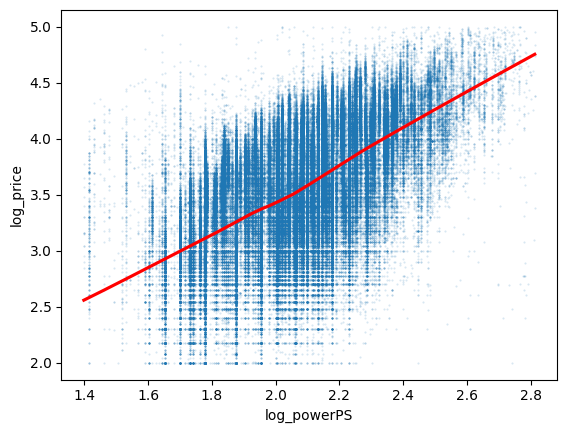

In [68]:
sns.regplot(
    data=cars_train,
    x='log_powerPS', 
    y='log_price',
    lowess=True,
    scatter_kws={'alpha': 0.2, 's': 0.2},
    line_kws={'color':'red'},
    );

This plot show that there is almost a linear relationship when using the log transformation. We could have tried some fractional power of `powerPS` as well, but let's keep it simple. In any case, this is useful knowledge for feature engineering.

### Kilometer vs Price
The pair plot shows that the relationships are less obvious for this pair of variables. Due to the discrete nature of the `kilometer` variable, we have to add a lot of horizontal jittering to avoid overplotting.

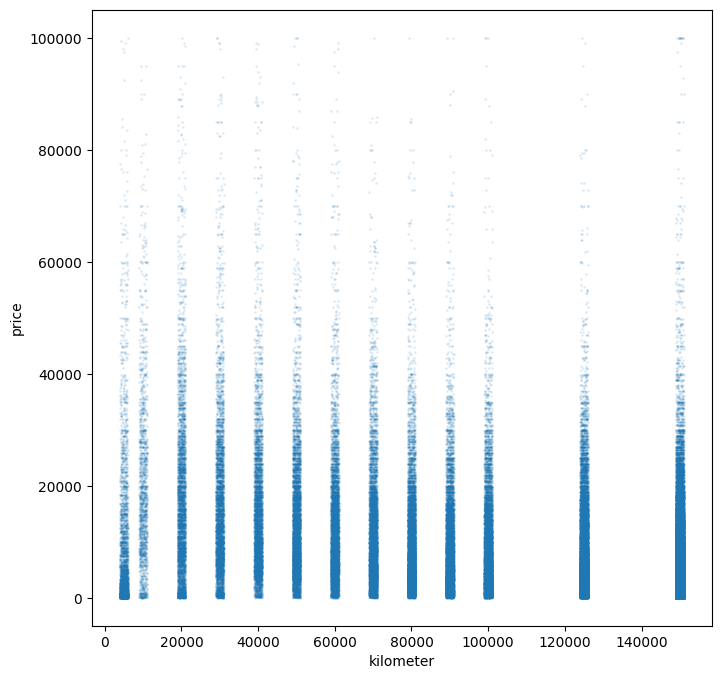

In [72]:
_ = plt.figure(figsize=(8, 8))
sns.regplot(
    data=cars_train,
    x='kilometer',
    y='price',
    fit_reg=False,
    scatter_kws={'alpha': 0.1, 's': 1},
    x_jitter=1_000,
);

In the natural space, it is very hard to see any kind of pattern. Let's look at price in the log space:

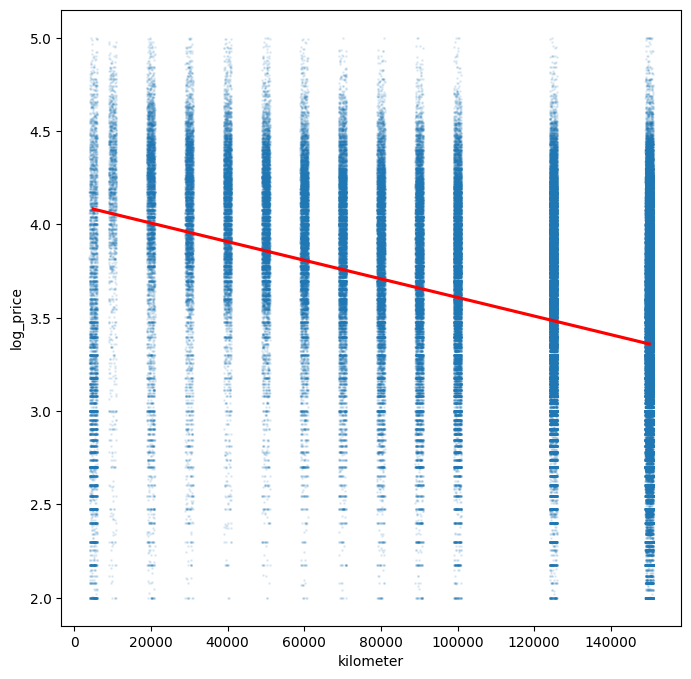

In [75]:
_ = plt.figure(figsize=(8, 8))
sns.regplot(
    data=cars_train,
    x='kilometer',
    y='log_price',
    fit_reg=True,
    scatter_kws={'alpha': 0.1, 's': 1},
    line_kws={'color': 'red'},
    x_jitter=1_000,
);

Now the correlation is more apparent, albeit with a lot of noise. We can also see a bunch of observations at 5,000km that have very low prices. This is very likely either error inputs, or inputs designed to "play" the search engine by ensuring these cars appear in as many searches as possible. These examples present a real dilemma. They are clearly going to cause under-estimated predictions for vehicles with 5,000km, regardless of the model class we train. They could also impact other predictions, depending on the model class: For instance, a linear regression model will fit a shallower slope due to these observations, which will impact predictions even on models with 100,000km for instance. Other classes of models, such as decision trees, would be able to better restrict the "contamination". To mitigate the negative impact on linear regression models, we could also finally decide to treat `kilometer` as a discrete, ordinal variable.

In any case, this advocates for some form of intervention to improve data quality. If `price` was one of the feature variables, we could use some heuristic to replace the values by something that we thought is more accurate, but here we are dealing with the target variable. The choice we have is either to keep, or to drop, these observations.

Are we allowed to do this? After all, the test set has the same data quality issues, and we shouldn't manipulate it to make it easier to predict... This is correct if all we care for is to do well on the test set. However, let's go back to the end goal of our project: developping a website that recommends selling prices to car owners. Now imagine a user whose vehicle has less than 5,000km. They don't want to be recommended a random price just because other users tried to game the eBay website. In other words, what we are really interested in is doing well on real-life examples, rather than the test set. This is one case where the test set is not fully representative of real life. There is no perfect solution unless we can get more representative examples to train and test on. 

In [76]:
len(cars_train.query("kilometer <= 5000"))

4880

Dropping them would this cost us about 4,500 data points.

In [77]:
cars_train_no5000km = cars_train.query('kilometer > 5000')

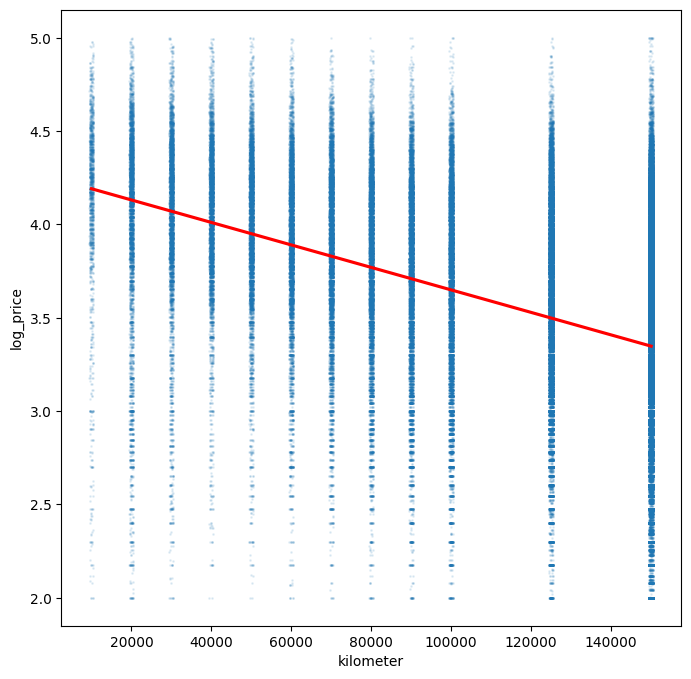

In [79]:
_ = plt.figure(figsize=(8, 8))
sns.regplot(
    data=cars_train_no5000km,
    x='kilometer',
    y='log_price',
    fit_reg=True,
    scatter_kws={'alpha': 0.1, 's': 1},
    line_kws={'color': 'red'},
    x_jitter=500,
);

The plot definitely looks cleaner. We still have a clear negative correlation.

The boxplot representation (considering `kilometer` as a discrete ordinal variable) is perhaps easier to read and shows the same trend:

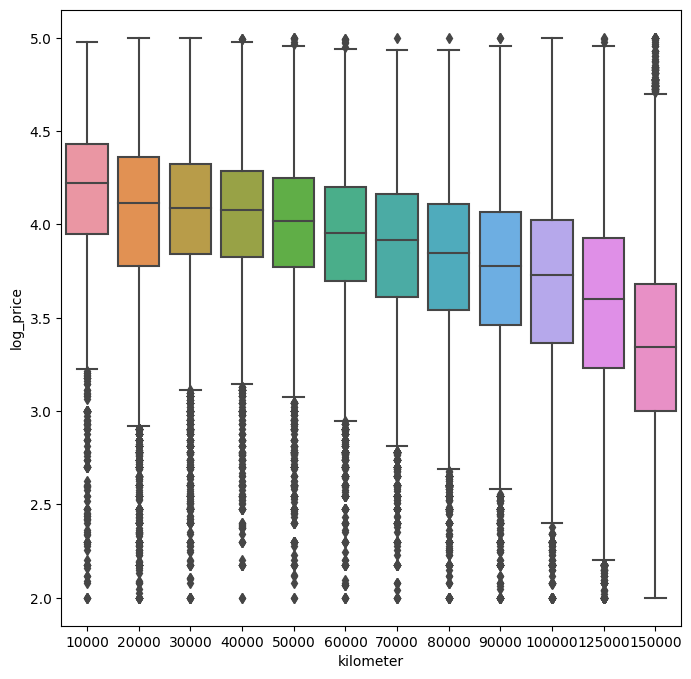

In [80]:
_ = plt.figure(figsize=(8,8))
sns.boxplot(data=cars_train_no5000km, x='kilometer', y='log_price');

For now, let us keep these observatoins, but we should try models with and without them and compare how they perform.

## Pairs involving categorical variables



In [85]:
cat_vars = cars_train.select_dtypes(['category']).columns
cat_vars = [c for c in cat_vars if c != 'model']  # exclude model that has too many categories for visualisation

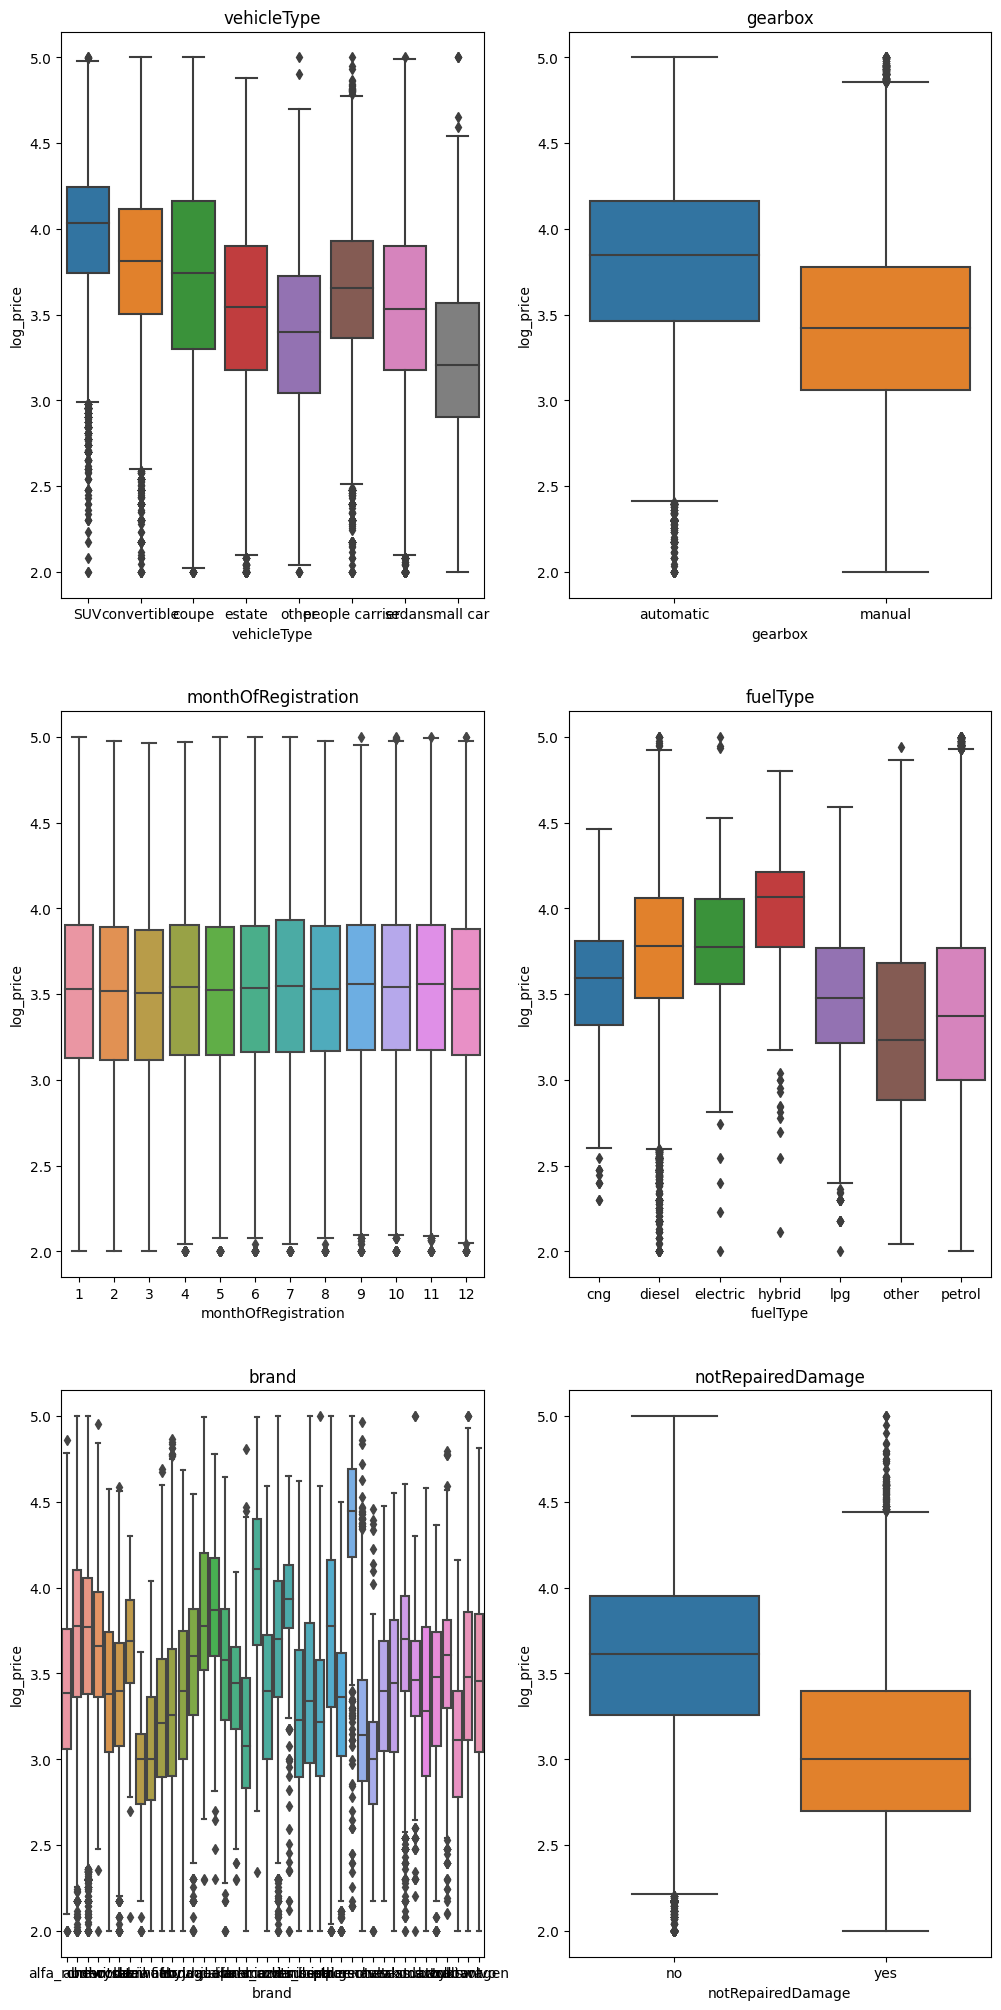

In [86]:
f, axes = plt.subplots(3, 2, figsize=(12, 25))
for i, c in enumerate(cat_vars):
    ax=axes[i//2, i%2]
    sns.boxplot(data=cars_train, x=c, y='log_price', ax=ax);
    ax.set_title(c)

The `brand` plot is somewhat hard to read (thankfully, we removed the `model` variable!). The other plots show that there are significant differences in prices across different labels of each categorical variable, with the exception of `monthOfRegistration` that does not seem to have much of an impact.
`brand` in particular has large differences (as we would expect), but adding that many categories to our model would cause the number of features to be quite high. We might want to group these brands according to some criteria. That's something we will be looking into when we move on to feature engineering.

## Other combinations of variables

We can experiment with 2 or more features in combination with `price`. The following plots are quite slow to build, so let's use a random subset of the data. 

In [91]:
cars_small = cars_train.loc[np.random.choice(cars_train.index, 50000, replace=False)]
cars_small_petr_dies = cars_small.loc[cars_small["fuelType"].isin(['petrol', 'diesel'])]
cars_small_petr_dies.loc[:, 'fuelType'] = cars_small_petr_dies.fuelType.cat.remove_unused_categories()

C:\Users\lucfr\AppData\Local\Temp\ipykernel_35596\3332494789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_small_petr_dies.loc[:, 'fuelType'] = cars_small_petr_dies.fuelType.cat.remove_unused_categories()
C:\Users\lucfr\AppData\Local\Temp\ipykernel_35596\3332494789.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cars_small_petr_dies.loc[:, 'fuelType'] = cars_small_petr_dies.fuelType.cat.remove_unused_categories()


For the fuel type, let's only consider the two main ones (Petrol and Diesel), as the other ones are insignificant in numbers (remember, this was in 2016). Recall also that when we considered all fuel types, we found an almost linear relationship between `log_powerPS` and `log_price`. Let's see how this looks when separating fuel types:

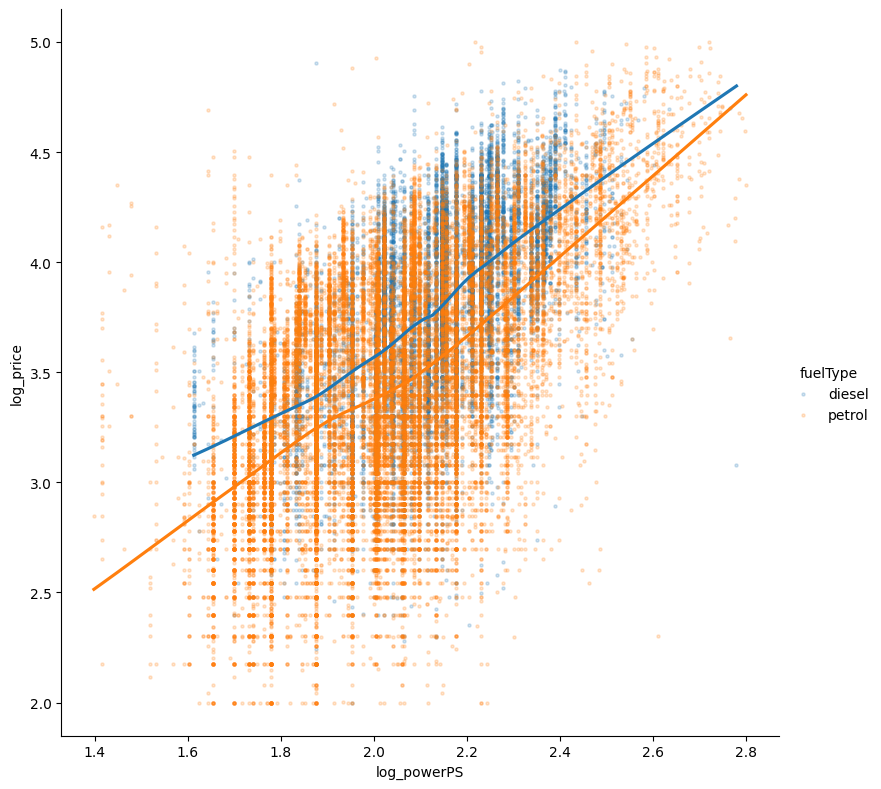

In [94]:
sns.lmplot(
    data=cars_small_petr_dies, 
    x='log_powerPS', 
    y='log_price', 
    hue='fuelType',
    lowess=True,
    scatter_kws={'s': 5, 'alpha': 0.2},
    height=8
);

So we see that both fuel types have a similar relationship, just shifted vertically. Diesel prices are not quite linear in the log-log space, but let's stick with that for simplicity.

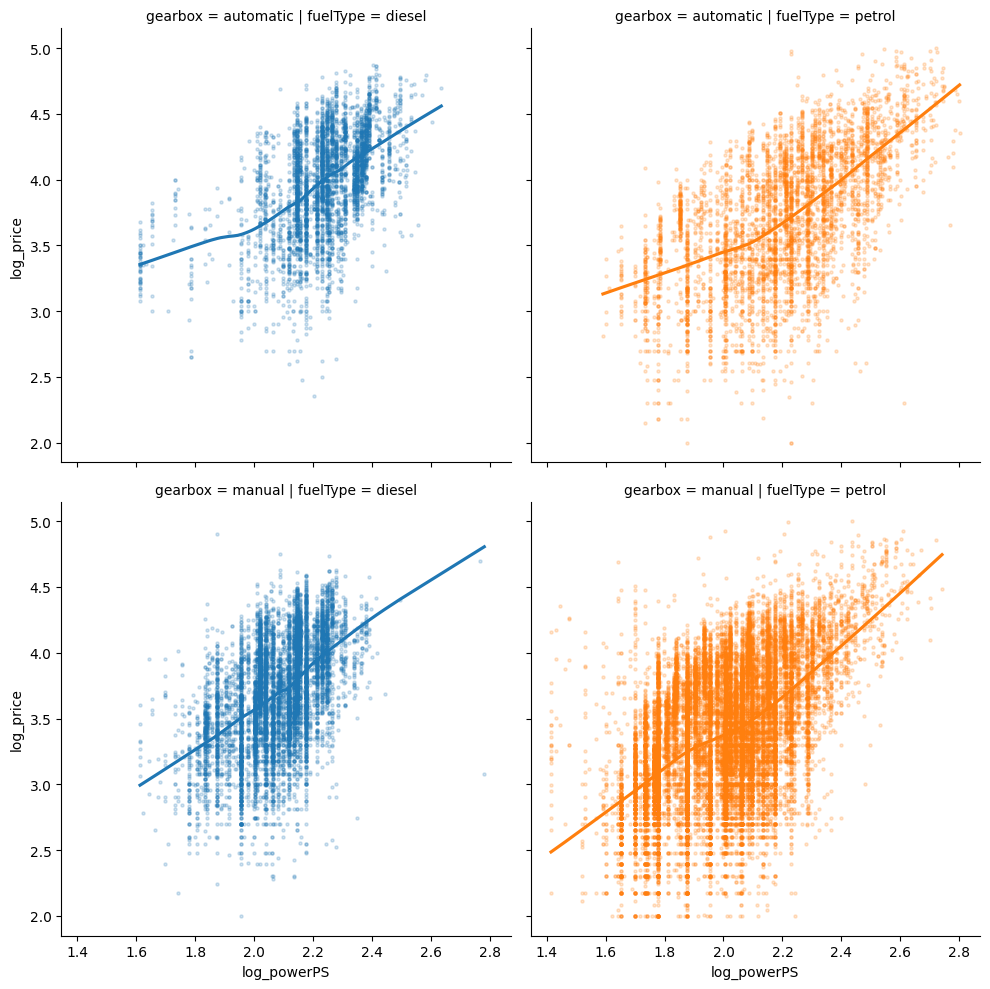

In [95]:
sns.lmplot(
    data=cars_small_petr_dies, 
    x='log_powerPS', 
    y='log_price', 
    hue='fuelType',
    col='fuelType',
    row='gearbox',
    lowess=True,
    scatter_kws={'s': 5, 'alpha': 0.2},
);

Looking at these plots, we notice several things:
- Automatic vehicles are generally more powerfull than manual ones
- The distribution of power and price is more compact for Diesel vehicles
- The relationships are roughly linear beyond 100PS (`log_powerPS` = 2); before that they are also roughtly linear but with either a different slope or a different intercept. This means that if we were to fit a linear regression, we might want to add an indicator variable for whether `powerPS` is below or above 100PS.

## Getting External Geographical Data
The last thing we are going to look at is to try and make `postalCode` more usable. If we think there is be some kind of structure in the relationship between it and `price` (or `log_price`), it is fair to assume that it will appear more easily when looking at post codes from a geographical perspective rather than looking at their strings. 
We can get a dataset mapping German postcodes to their latitude and longitude [here](https://github.com/WZBSocialScienceCenter/plz_geocoord). Once the file is downloaded and unzipped, we can merge the two datasets:

In [97]:
postcodes = pd.read_csv(
    "data/plz_geocoord.csv",
    names=['postcode', 'lat', 'long'],
    header=0,
    dtype={'postcode': 'object'}
)
postcodes.head()

postcode        lat       long
0    01067  51.057550  13.717065
1    01069  51.039135  13.737675
2    01097  51.065908  13.736152
3    01099  51.087188  13.802804
4    01108  51.144324  13.799706

In [98]:
cars_small = pd.merge(cars_small, postcodes, left_on='postalCode', right_on='postcode', how='left')
cars_small.head()

price vehicleType  yearOfRegistration    gearbox  powerPS   model  \
0  8850.0      estate              2005.0     manual    163.0     3er   
1  1800.0      estate              2005.0     manual      NaN  vectra   
2   200.0   small car              1995.0     manual     45.0   corsa   
3   900.0      estate              2001.0  automatic    150.0   omega   
4  3999.0      estate              2005.0  automatic    165.0   other   

   kilometer monthOfRegistration fuelType   brand notRepairedDamage  \
0     150000                  11   diesel     bmw                no   
1     150000                   9   diesel    opel               NaN   
2     150000                 NaN   petrol    opel                no   
3     150000                   6      cng    opel                no   
4     150000                   1   petrol  subaru                no   

  dateCreated postalCode            lastSeen  log_price  log_powerPS postcode  \
0  2016-03-11      27572 2016-03-22 07:47:18   3.946943     2.212188    27572   
1  2016-03-11      32602 2016-03-12 07:17:53   3.255273          NaN    32602   
2  2016-03-08      25566 2016-03-22 23:45:57   2.301030     1.653213    25566   
3  2016-03-18      19258 2016-04-02 00:15:28   2.954243     2.176091    19258   
4  2016-03-13      57339 2016-03-13 20:42:13   3.601951     2.217484    57339   

         lat       long  
0  53.505518   8.598558  
1  52.148026   8.830185  
2  53.865984   9.583818  
3  53.403586  10.761518  
4  50.989136   8.254531

Now we need to manipulate the data to be able to build a heat map. First, we discretise the latitude and longitude values, and compute the mean of `log_price` for each bin:

In [99]:
cars_binned = cars_small.copy()
cars_binned['lat_bin'] = pd.cut(cars_binned.lat, 30)
cars_binned['long_bin'] = pd.cut(cars_binned.long, 30)
cars_grouped = cars_binned[['lat_bin', 'long_bin', 'log_price']].groupby(['lat_bin', 'long_bin']).mean().reset_index()
cars_grouped.head()

lat_bin        long_bin  log_price
0  (47.352, 47.612]  (5.973, 6.282]        NaN
1  (47.352, 47.612]  (6.282, 6.581]        NaN
2  (47.352, 47.612]  (6.581, 6.881]        NaN
3  (47.352, 47.612]  (6.881, 7.181]        NaN
4  (47.352, 47.612]  (7.181, 7.481]        NaN

Now we have to pivot the data to make it wide:

In [100]:
cars_pivot = cars_grouped.pivot(index='lat_bin', columns='long_bin', values='log_price')
cars_pivot.head()

long_bin          (5.973, 6.282]  (6.282, 6.581]  (6.581, 6.881]  \
lat_bin                                                            
(47.352, 47.612]             NaN             NaN             NaN   
(47.612, 47.865]             NaN             NaN             NaN   
(47.865, 48.117]             NaN             NaN             NaN   
(48.117, 48.37]              NaN             NaN             NaN   
(48.37, 48.622]              NaN             NaN             NaN   

long_bin          (6.881, 7.181]  (7.181, 7.481]  (7.481, 7.78]  (7.78, 8.08]  \
lat_bin                                                                         
(47.352, 47.612]             NaN             NaN       3.496377      3.394527   
(47.612, 47.865]             NaN             NaN       3.451725      3.551024   
(47.865, 48.117]             NaN             NaN       3.552125      3.509332   
(48.117, 48.37]              NaN             NaN       3.581103      3.409103   
(48.37, 48.622]              NaN             NaN       3.087534      3.498574   

long_bin          (8.08, 8.38]  (8.38, 8.68]  (8.68, 8.98]  ...  \
lat_bin                                                     ...   
(47.352, 47.612]      3.960794      3.621965           NaN  ...   
(47.612, 47.865]      3.694613      3.471429      3.449869  ...   
(47.865, 48.117]      3.374915      3.473637      3.534758  ...   
(48.117, 48.37]       3.319332      3.479798      3.511376  ...   
(48.37, 48.622]       3.529018      3.576036      3.511248  ...   

long_bin          (11.978, 12.277]  (12.277, 12.577]  (12.577, 12.877]  \
lat_bin                                                                  
(47.352, 47.612]               NaN               NaN          3.475671   
(47.612, 47.865]          3.641070          3.682437          3.584755   
(47.865, 48.117]          3.382291          3.617224          3.584677   
(48.117, 48.37]           3.660846          3.494103          3.543539   
(48.37, 48.622]           3.603845          3.606403          3.481965   

long_bin          (12.877, 13.177]  (13.177, 13.476]  (13.476, 13.776]  \
lat_bin                                                                  
(47.352, 47.612]               NaN               NaN               NaN   
(47.612, 47.865]          3.654361               NaN               NaN   
(47.865, 48.117]          3.707403               NaN               NaN   
(48.117, 48.37]           3.626842          3.555623               NaN   
(48.37, 48.622]           3.558094          3.582388          3.526701   

long_bin          (13.776, 14.076]  (14.076, 14.376]  (14.376, 14.676]  \
lat_bin                                                                  
(47.352, 47.612]               NaN               NaN               NaN   
(47.612, 47.865]               NaN               NaN               NaN   
(47.865, 48.117]               NaN               NaN               NaN   
(48.117, 48.37]                NaN               NaN               NaN   
(48.37, 48.622]                3.0               NaN               NaN   

long_bin          (14.676, 14.975]  
lat_bin                             
(47.352, 47.612]               NaN  
(47.612, 47.865]               NaN  
(47.865, 48.117]               NaN  
(48.117, 48.37]                NaN  
(48.37, 48.622]                NaN  

[5 rows x 30 columns]

Finally, here is the heat map. Remember that the scale is in the log space:

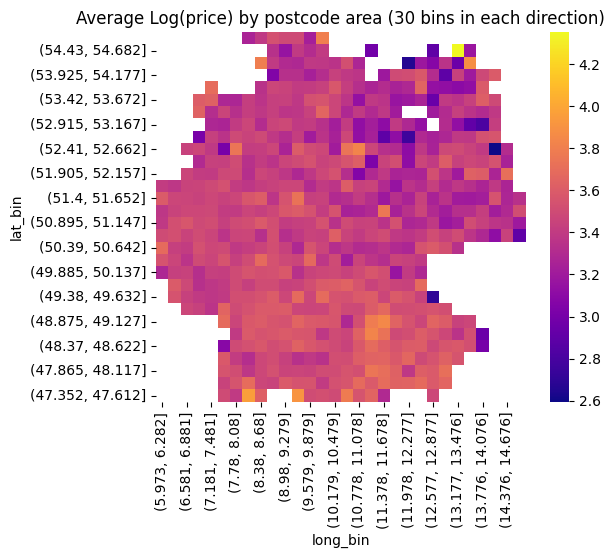

In [103]:
sns.heatmap(cars_pivot, square=True, cmap='plasma')
plt.title("Average Log(price) by postcode area (30 bins in each direction)")
plt.gca().invert_yaxis();

There definitely seems to be geographical differences in the price distribution. In particular, prices seem lower in the former East Germany. Whether this is due to lower standards of cars in general, or lower prices for the same cars, is not clear. Conversely, prices are higher in Bavaria (South-East).

## Conclusion
We could keep exploring the data for much longer, but hopefully this example has given you a taste of what EDA looks like and what to be looking for. Some key take-outs:
- Always keep your endgame in mind. This will inform your investigations and help you make decisions.
- Domain knowledge is key to understand your data, both in terms of its schema and the patterns found. It also helps you decide what to look for, and identify issues.